# MPS practical 
### (13/02/2025) - ENES Bioacoustics Lab

##### MPS is like a two-dimensional fingerprint of a sound = It shows both the overall rhythm (slow, periodic changes) and the detailed harmonic structure (fast, fine variations) that define a sound’s unique character.

### How to compute MPS with Python?

#### Import packages

In [ ]:
import numpy as np

import librosa
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import cm as cmap

from copy import deepcopy

import copy
import io
import scipy.io.wavfile as wav

from IPython.display import Audio, display, clear_output
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Layout, Button, IntSlider, FloatSlider, Checkbox, Dropdown


## Introduction

### Generate a simple sine wave

In [1]:
sr = 44100  # Sample rate
duration = 3


In [2]:
t = np.linspace(0, duration, int(sr * duration)) # 66150 total points evenly spaced from 0 to 3 seconds


NameError: name 'np' is not defined

In [ ]:
sine_wave = 0.5 * np.sin(2 * np.pi * 440 * t)


-  440 is the frequency in Hz (cycles per second)

-  $ 2 * π * 440 $ converts to angular frequency $ (ω = 2πf) $. This is because one complete sine wave cycle is 2π radians

-  t multiplies this by each time point

-  np.sin() takes these angles and produces values between -1 and 1

-  0.5 is the amplitude, scaling the wave to range from -0.5 to 0.5

-  In classical wave equation form, this is: $ y(t) = A * sin(2πft) $


### Plot and play the sine wave

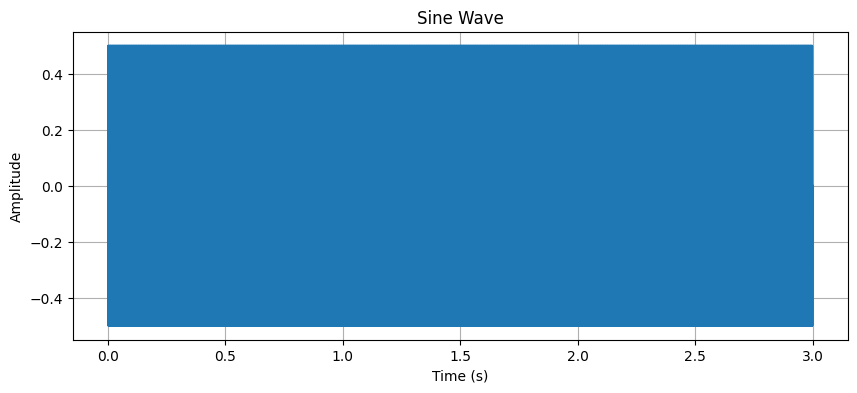

In [ ]:
# Plot using plain matplotlib
plt.figure(figsize=(10, 4))
plt.plot(t, sine_wave)  # Plot first 1000 samples for better visibility
plt.title('Sine Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


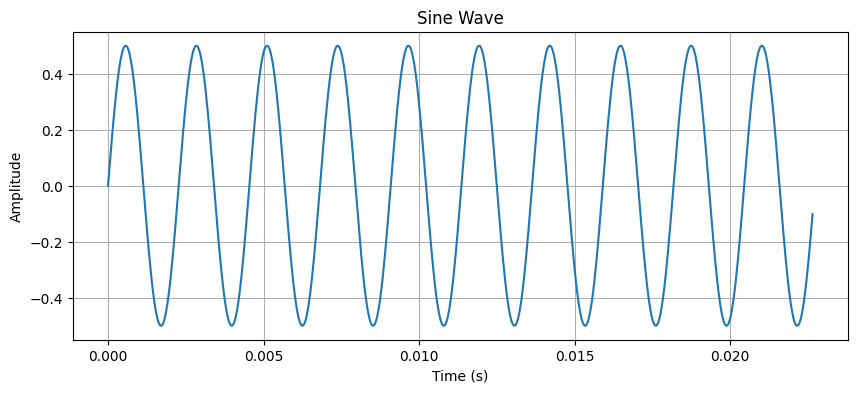

In [ ]:
# Plot using plain matplotlib
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], sine_wave[:1000])  # Plot first 1000 samples for better visibility
plt.title('Sine Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Create playable audio widget
Audio(sine_wave, rate=sr)


### Generate a sine wave increasing lineary 

In [ ]:
freq = np.linspace(100, 3000, len(t)) 
phase = 2 * np.pi * np.cumsum(freq) / sr
lin_inc_wave = 0.5 * np.sin(phase)


- freq = np.linspace(800, 200, len(t)) : frequency f(t) decreasing linearly with time, from 800 to 200 Hz

- phase = 2 * np.pi * np.cumsum(freq) / sr : as we said $ y(t) = A * sin(2πft) $, however f is not constant here the phase angle $ 2πft $ becomes: $ θ(t) = 2π∫f(t)dt $

- In discrete time (which is what we have), this integral becomes a sum: $ phase = 2 * np.pi * np.cumsum(freq) / sr $

- Finally, lin_inc_wave = 0.5 * np.sin(phase): this is just a regular sin wave

In [ ]:
Audio(lin_inc_wave, rate=sr)


### Generate a sine wave decreasing exponentially

In [ ]:
# Create exponentially decreasing frequency from 200 Hz to 1200 Hz
freq = np.geomspace(1200, 200, len(t))
phase = 2 * np.pi * np.cumsum(freq) / sr
exp_dec_wave = 0.5 * np.sin(phase)


In [ ]:
Audio(exp_dec_wave, rate=sr)


### Generate a sine wave with vibrato  
(frequency modulation)

In [ ]:
# Parameters
center_freq = 440  # Center frequency (Hz)
vibrato_rate = 3   # How many oscillations per second (Hz)
vibrato_depth = 30 # How far the frequency deviates (Hz)

# Create the frequency modulation
freq = center_freq + vibrato_depth * np.sin(2 * np.pi * vibrato_rate * t)

# Calculate phase through frequency integration
phase = 2 * np.pi * np.cumsum(freq) / sr

# Create the vibrato signal
vibrato_wave = 0.5 * np.sin(phase)


In [ ]:
Audio(vibrato_wave, rate=sr)


### Generate a sine wave with amplitude modulation  
(amplitude modulation)

In [ ]:
# Carrier signal (main frequency)
carrier_freq = 440  # Hz
carrier = np.sin(2 * np.pi * carrier_freq * t)

# Modulation signal (envelope)
mod_freq = 2  # How many oscillations per second (Hz) 
mod_depth = 0.8  # How much the amplitude varies (0 to 1)
modulator = 1 + mod_depth * np.sin(2 * np.pi * mod_freq * t)

# Create AM signal
am_wave = carrier * modulator

# Normalize to avoid clipping
am_wave = 0.5 * am_wave / np.max(np.abs(am_wave))


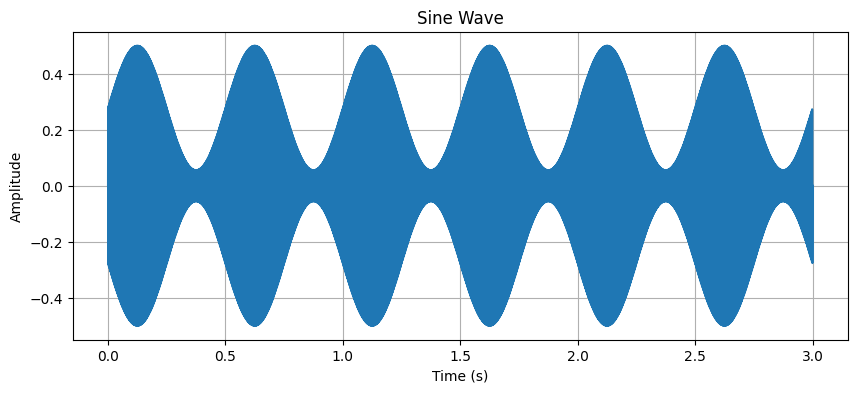

In [ ]:
# Plot using plain matplotlib
plt.figure(figsize=(10, 4))
plt.plot(t, am_wave)  
plt.title('Sine Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Create playable audio widget
Audio(am_wave, rate=sr)


# (MPS -> amplitude and frequency modulation contains the information)

### Generate a sine wave with harmonics

In [ ]:
def generate_harmonics(fundamental, duration, sr=44100, num_harmonics=10, cycles_khz=2):
    """
    Generate a wave with harmonics every 500 Hz above the fundamental
    """
    t = np.linspace(0, duration, int(sr * duration))
    wave = np.zeros_like(t)
    
    # Calculate how many harmonics we can have before hitting Nyquist frequency
    max_freq = sr / 2
    current_freq = fundamental
    harmonic_num = 0
    
    while current_freq < max_freq and harmonic_num < num_harmonics:
        # Amplitude decreases with frequency - using inverse proportion
        amplitude = 1.0 / (harmonic_num + 1)
        wave += amplitude * np.sin(2 * np.pi * current_freq * t)
        
        current_freq += 1000/cycles_khz
        harmonic_num += 1
    
    # Normalize
    wave = 0.5 * wave / np.max(np.abs(wave))
    return wave


In [ ]:
harm_500_wave = generate_harmonics(150, duration, num_harmonics=10, cycles_khz=2)
Audio(harm_500_wave, rate=sr)


In [ ]:
harm_1500_wave = generate_harmonics(150, duration, num_harmonics=10, cycles_khz=0.75)
Audio(harm_1500_wave, rate=sr)


### Compute and visualize the fourrier transform  
(How the energy is distributed across the frequencies)

In [ ]:
# Compute the FFT
fft_result = np.fft.fft(sine_wave)
fft_freq = np.fft.fftfreq(len(t), 1/sr)

# We only need the positive frequencies
positive_freq_mask = fft_freq >= 0
fft_freq = fft_freq[positive_freq_mask]
fft_magnitude = np.abs(fft_result[positive_freq_mask])


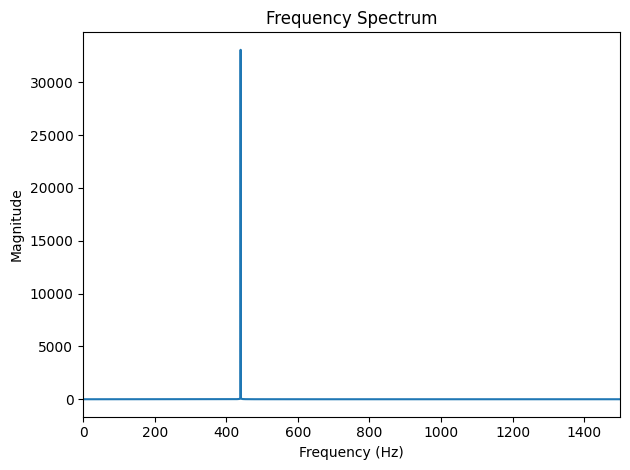

In [ ]:
plt.plot(fft_freq, fft_magnitude)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 1500) 

plt.tight_layout()
plt.show()


(All the energy is in 440 hz -> sin wave was created with 440 hz)

### Add fade in/out to avoid clicks
fade_duration = 0.05  # 10ms
fade_length = int(fade_duration * sr)
fade_in = np.linspace(0, 1, fade_length)
fade_out = np.linspace(1, 0, fade_length)

lin_inc_wave[:fade_length] *= fade_in
lin_inc_wave[-fade_length:] *= fade_out

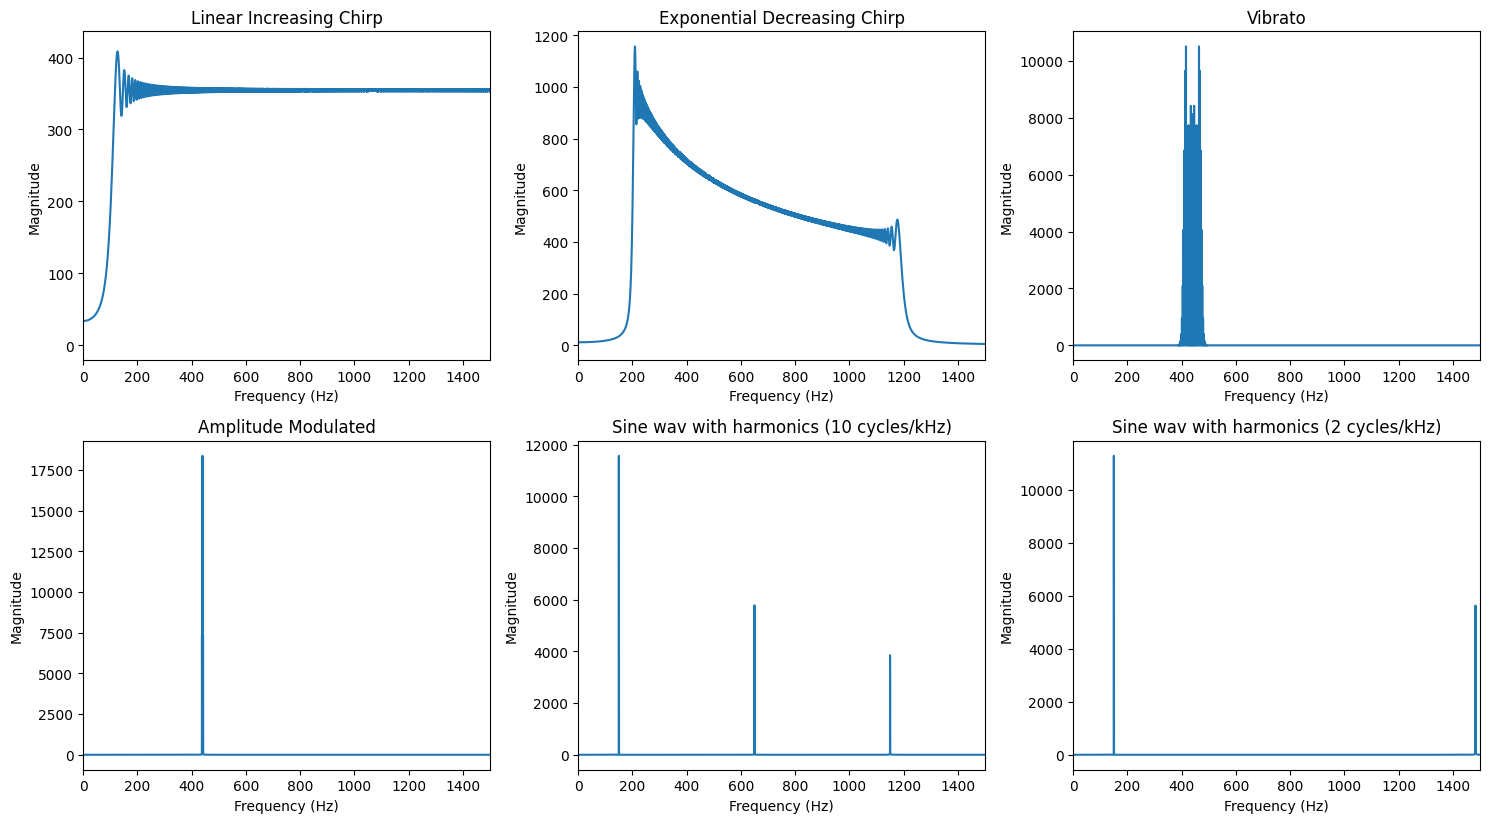

In [ ]:
waves = [lin_inc_wave, exp_dec_wave, vibrato_wave, am_wave, harm_500_wave, harm_1500_wave] # Signals created before
titles = ['Linear Increasing Chirp', 'Exponential Decreasing Chirp', 'Vibrato', 'Amplitude Modulated', 'Sine wav with harmonics (10 cycles/kHz)', 'Sine wav with harmonics (2 cycles/kHz)']

# Create 2x2 subplot
plt.figure(figsize=(15, 12))

for i, wave in enumerate(waves):
    # Compute FFT
    fft_result = np.fft.fft(wave)
    fft_freq = np.fft.fftfreq(len(t), 1/sr)
    
    # Get positive frequencies
    positive_freq_mask = fft_freq >= 0
    fft_freq = fft_freq[positive_freq_mask]
    fft_magnitude = np.abs(fft_result[positive_freq_mask])
    
    # Create subplot
    plt.subplot(3, 3, i+1)
    plt.plot(fft_freq, fft_magnitude)
    plt.title(titles[i])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 1500)  # Adjust this based on your maximum frequency
    plt.grid(False)

plt.tight_layout()
plt.show()


### Compute and visualize spectrograms

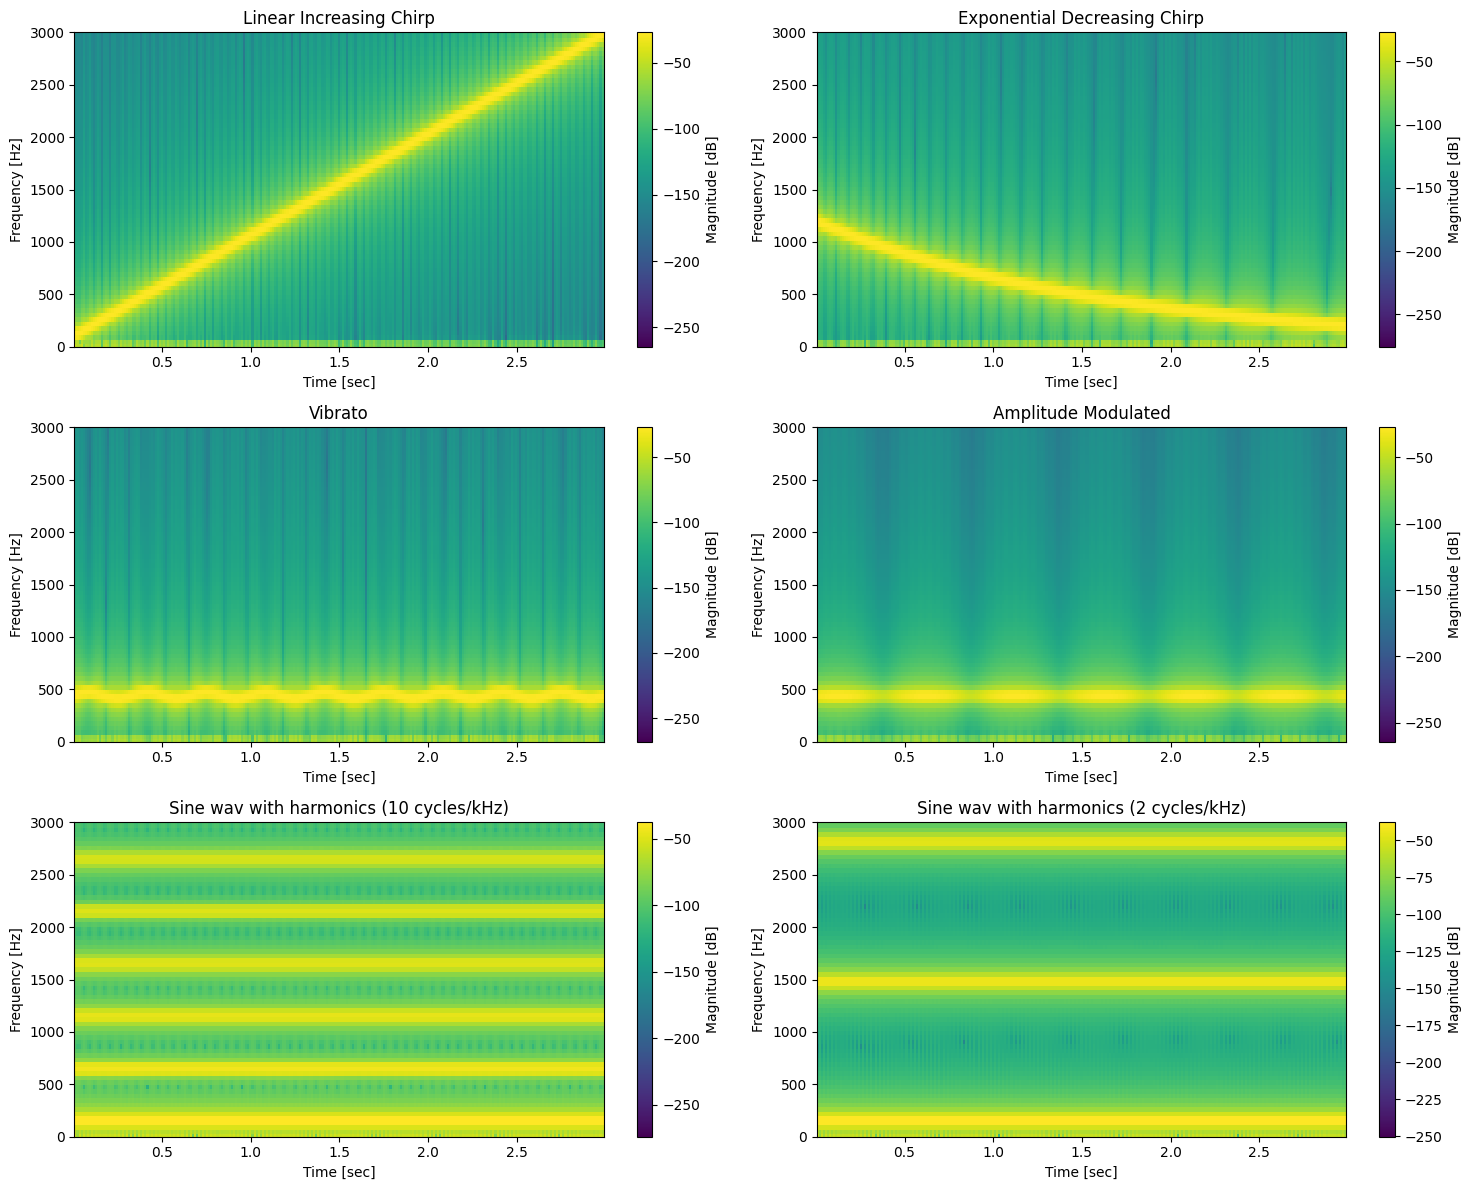

In [ ]:
# Parameters for spectrogram
nperseg = 1024  # Length of each segment
noverlap = 512  # Number of points to overlap
window = signal.windows.hann(nperseg)  # Hanning window

plt.figure(figsize=(15, 12))

for i, wave in enumerate(waves):
    # Compute spectrogram
    frequencies, times, Sxx = signal.spectrogram(wave, sr, 
                                               window=window,
                                               nperseg=nperseg, 
                                               noverlap=noverlap)
    
    
    # Convert to dB
    Sxx_db = 10 * np.log10(Sxx)
    
    # Set values below 80 dB to zero
    #Sxx_db[Sxx_db < -50] = -300
    
    # Plot
    plt.subplot(3, 2, i+1)
    plt.pcolormesh(times, frequencies, Sxx_db)
    plt.title(titles[i])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0, 3000)  # Limit frequency display to 1500 Hz
    plt.colorbar(label='Magnitude [dB]')

plt.tight_layout()
plt.show()


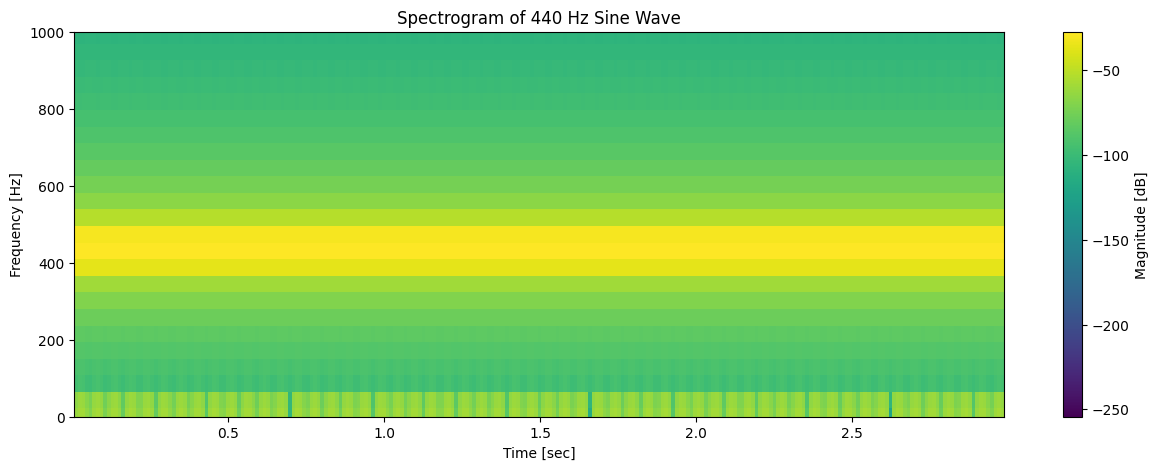

In [ ]:
nperseg = 1024
noverlap = 512
window = signal.windows.hann(nperseg)

frequencies, times, Sxx = signal.spectrogram(sine_wave, sr, 
                                           window=window,
                                           nperseg=nperseg, 
                                           noverlap=noverlap)

plt.figure(figsize=(15, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.title('Spectrogram of 440 Hz Sine Wave')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude [dB]')
plt.ylim(0, 1000)  # Focus on lower frequencies
plt.show()


## Let's start with MPS!

#### First, we compute a normalized version of the spectrogram with a threshold (comparative analysis + reduce background noise)  
## ( Normalize the magnitude to remove the effect of distance and apply the threshold to reduce noise)

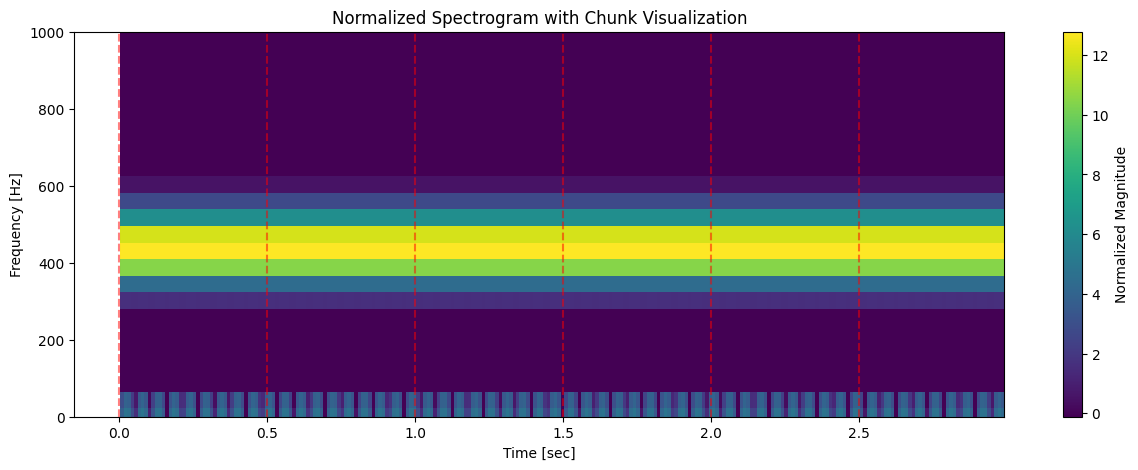

In [ ]:
# Convert to dB, normalize with 50dB threshold
Sxx_db = 10 * np.log10(Sxx)
maxdata = Sxx_db.max()
mindata = maxdata - 50  # dbRES = 50
Sxx_db[Sxx_db < mindata] = mindata
Sxx_norm = Sxx_db - Sxx_db.mean()
Sxx_norm /= Sxx_db.std()

# Calculate nWindow from window_size
window_size = 0.5  # seconds
nWindow = np.where(times >= window_size)[0][0]
if nWindow % 2 == 0:
    nWindow += 1

# Show chunking process
plt.figure(figsize=(15, 5))
plt.pcolormesh(times, frequencies, Sxx_norm)
plt.title('Normalized Spectrogram with Chunk Visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Normalized Magnitude')
plt.ylim(0, 1000)

# Draw vertical lines to show chunks
chunk_times = np.arange(0, times[-1], window_size)
for chunk_time in chunk_times:
    plt.axvline(x=chunk_time, color='r', linestyle='--', alpha=0.5)
plt.show()


#### We create a function to obtain a gaussian window in order to reduce overlap effect with the MPS windows

In [ ]:
def gaussian_window(N, nstd):
    hnwinlen = (N + (1-N%2)) // 2
    gauss_t = np.arange(-hnwinlen, hnwinlen+1, 1.0)
    gauss_std = float(N) / float(nstd)
    gauss_window = np.exp(-gauss_t**2 / (2.0*gauss_std**2)) / (gauss_std*np.sqrt(2*np.pi))
    return gauss_t, gauss_window


#### We pad the spectrogram with zeros and center it if its too short

In [ ]:
# Zero pad spectrogram
pad_width = int((nWindow-1)/2)
sdata = np.pad(Sxx_norm, ((0,0), (pad_width, pad_width)), 
              mode='constant', constant_values=Sxx_norm.min())

# Select chunk from middle
tmid = len(times)//4
tstart = tmid - (nWindow-1)//2 - 1 + pad_width
tend = tmid + (nWindow-1)//2 + pad_width
chunk = deepcopy(sdata[:, tstart:tend])

# Get Gaussian window with correct parameters
_, wg = gaussian_window(nWindow, 6)


#### Here we show a chunk of the spectrogram after and before windowing

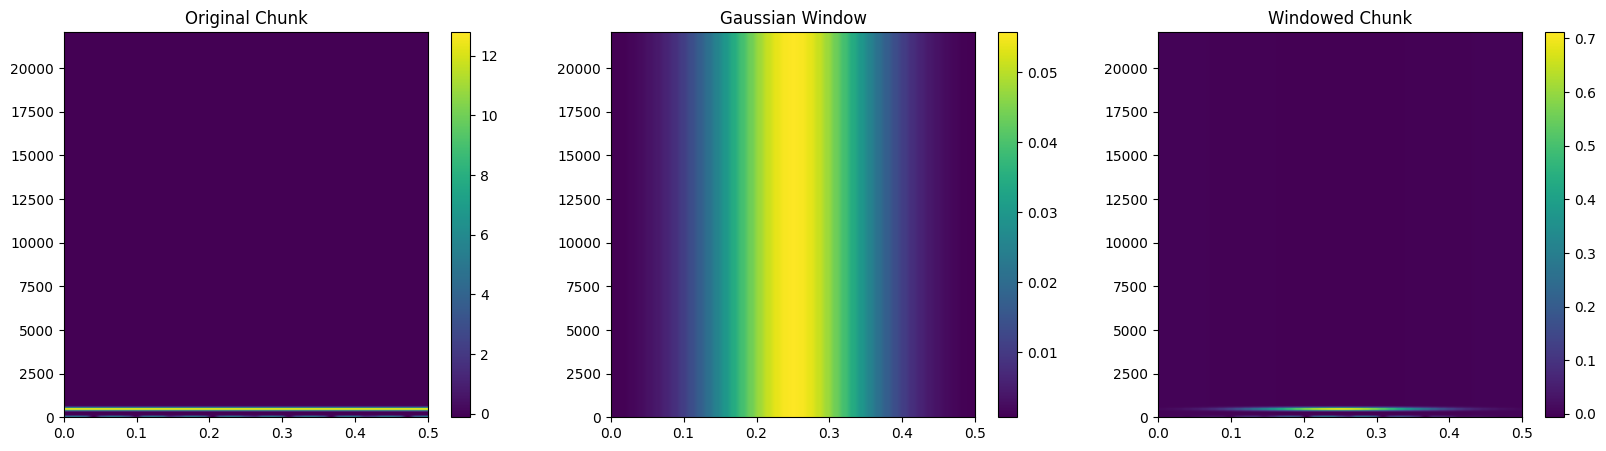

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Original chunk
im0 = axes[0].imshow(chunk, aspect='auto', origin='lower', 
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[0].set_title('Original Chunk')
plt.colorbar(im0, ax=axes[0])

# Gaussian window visualization
window_vis = np.tile(wg, (len(frequencies), 1))
im1 = axes[1].imshow(window_vis, aspect='auto', origin='lower',
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[1].set_title('Gaussian Window')
plt.colorbar(im1, ax=axes[1])

# Apply window per frequency
windowed_chunk = deepcopy(chunk)
for fInd in range(len(frequencies)):
    windowed_chunk[fInd,:] = chunk[fInd,:] * wg

im2 = axes[2].imshow(windowed_chunk, aspect='auto', origin='lower',
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[2].set_title('Windowed Chunk')
plt.colorbar(im2, ax=axes[2])
plt.show()


#### We apply a bidimensional Fourier transform to the chunk of the spectrogram = we obtained the MPS! 
(2D fft)    
(big red line = one pure sound -> still some artifacts because sounds are actually a composition of sound)

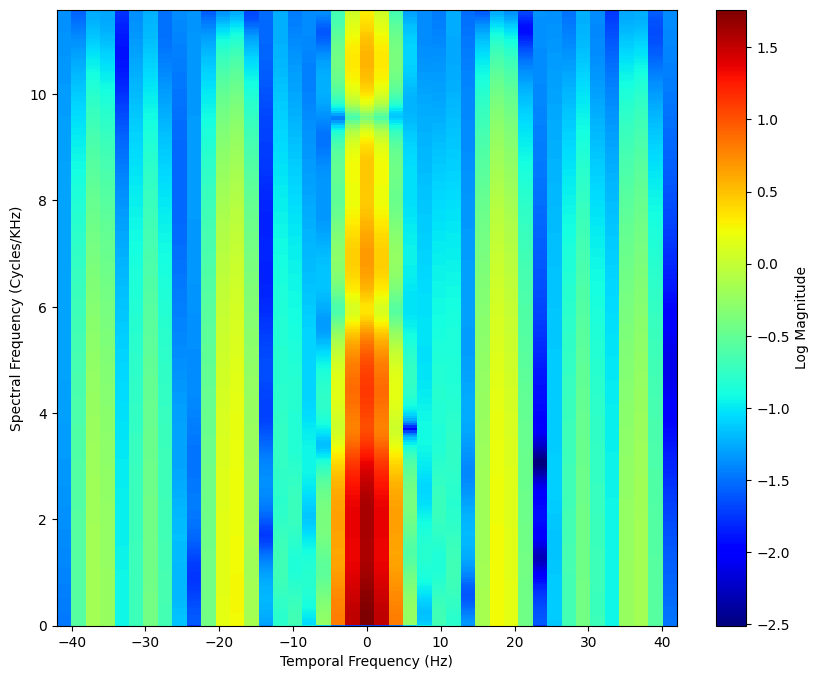

In [ ]:
# FFT and visualization
chunk_fft = np.fft.fft2(windowed_chunk)
chunk_fft_shifted = np.fft.fftshift(np.abs(chunk_fft))
spectral_freq = np.fft.fftfreq(chunk_fft.shape[0], d=frequencies[1]-frequencies[0])
temporal_freq = np.fft.fftfreq(chunk_fft.shape[1], d=window_size/chunk_fft.shape[1])

plt.figure(figsize=(10, 8))
ex = (temporal_freq.min(), temporal_freq.max(), 
      spectral_freq.min()*1e3, spectral_freq.max()*1e3)
plt.imshow(np.log10(chunk_fft_shifted), aspect='auto', origin='lower', extent=ex, cmap=cmap.jet, interpolation='nearest')
plt.ylim(bottom=0)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar(label='Log Magnitude')
plt.show()


### How does the 2D fourier transform work? 

In [ ]:
def visualize_fft2_steps(windowed_chunk, frequencies, window_size):
    """
    Visualize each step of the 2D FFT process for a spectrogram chunk
    
    Parameters:
    -----------
    windowed_chunk : 2D numpy array
        The input spectrogram chunk
    frequencies : array
        Frequency values
    window_size : int
        Size of the time window
    """
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Original Data
    plt.subplot(221)
    plt.imshow(windowed_chunk, aspect='auto', origin='lower', cmap='jet')
    plt.title('1. Original Spectrogram Chunk')
    plt.ylabel('Frequency Bin')
    plt.xlabel('Time Bin')
    plt.colorbar(label='Amplitude')
    
    # 2. FFT2 Result (magnitude)
    chunk_fft = np.fft.fft2(windowed_chunk)
    chunk_fft_mag = np.abs(chunk_fft)
    
    plt.subplot(222)
    plt.imshow(np.log10(chunk_fft_mag + 1e-10), aspect='auto', origin='lower', cmap='jet')
    plt.title('2. FFT2 Magnitude (Log Scale)')
    plt.ylabel('Spectral Frequency Bin')
    plt.xlabel('Temporal Frequency Bin')
    plt.colorbar(label='Log Magnitude')
    
    # 3. FFT2 Phase
    chunk_fft_phase = np.angle(chunk_fft)
    
    plt.subplot(223)
    plt.imshow(chunk_fft_phase, aspect='auto', origin='lower', cmap='jet')
    plt.title('3. FFT2 Phase')
    plt.ylabel('Spectral Frequency Bin')
    plt.xlabel('Temporal Frequency Bin')
    plt.colorbar(label='Phase (radians)')
    
    # 4. Shifted FFT2 (centered)
    chunk_fft_shifted = np.fft.fftshift(np.abs(chunk_fft))
    spectral_freq = np.fft.fftfreq(chunk_fft.shape[0], d=frequencies[1]-frequencies[0])
    temporal_freq = np.fft.fftfreq(chunk_fft.shape[1], d=window_size/chunk_fft.shape[1])
    
    # Get the extent for proper frequency labeling
    ex = (temporal_freq.min(), temporal_freq.max(), 
          spectral_freq.min()*1e3, spectral_freq.max()*1e3)
    
    plt.subplot(224)
    plt.imshow(np.log10(chunk_fft_shifted + 1e-10), aspect='auto', origin='lower', 
              extent=ex, cmap='jet')
    plt.title('4. Shifted FFT2 (Centered, Log Scale)')
    plt.ylabel('Spectral Frequency (Cycles/KHz)')
    plt.xlabel('Temporal Frequency (Hz)')
    plt.ylim(bottom=0)
    plt.colorbar(label='Log Magnitude')
    
    plt.tight_layout()
    plt.show()


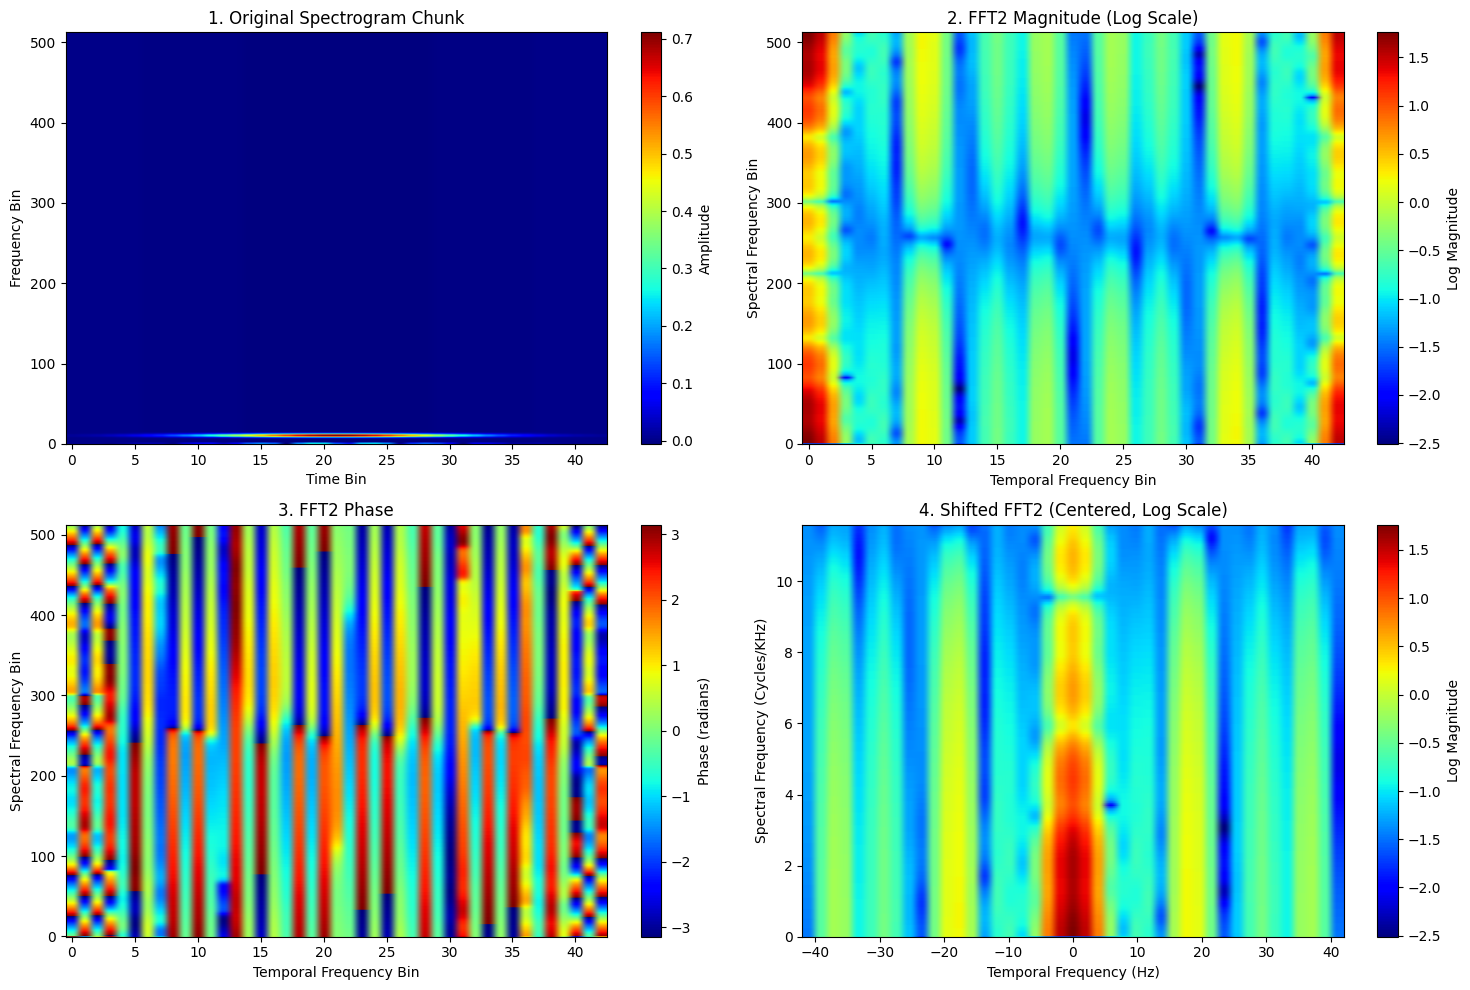

In [ ]:
visualize_fft2_steps(windowed_chunk, frequencies, window_size)


#### Final MPS = mean of all chunks

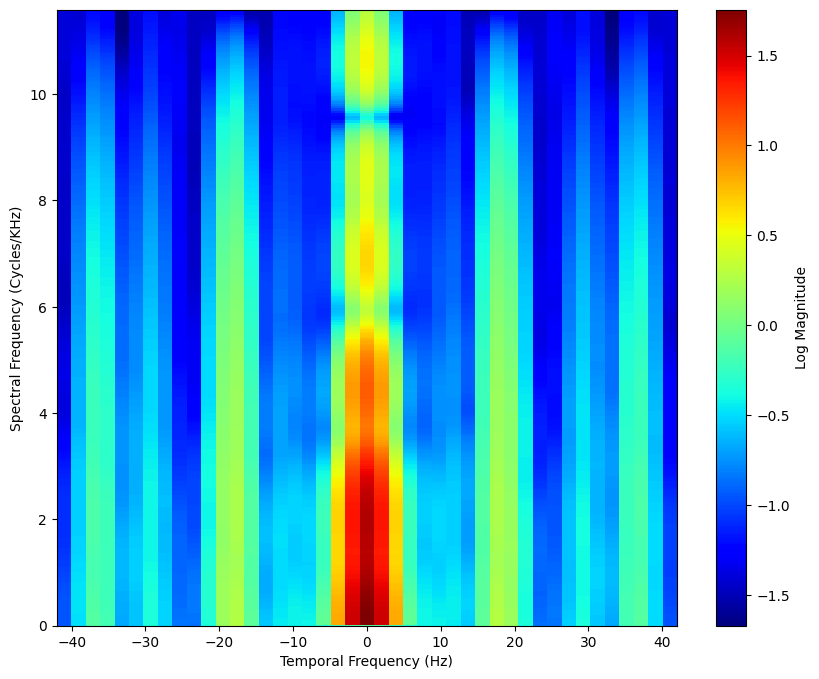

In [ ]:
# Process all chunks
mps_results = []
tShift = int(nWindow/3)

for tmid in range(tShift, len(times), tShift):
    tstart = tmid - (nWindow-1)//2 - 1 + pad_width
    tend = tmid + (nWindow-1)//2 + pad_width
    
    if tend > sdata.shape[1]:
        break
        
    chunk = deepcopy(sdata[:, tstart:tend])
    
    # Apply window per frequency
    windowed_chunk = deepcopy(chunk)
    for fInd in range(len(frequencies)):
        windowed_chunk[fInd,:] = chunk[fInd,:] * wg
        
    # 2D FFT
    chunk_fft = np.fft.fft2(windowed_chunk)
    mps_results.append(np.abs(chunk_fft))

# Average and plot
mps_final = np.mean(mps_results, axis=0)
mps_final_shifted = np.fft.fftshift(mps_final)

plt.figure(figsize=(10, 8))
ex = (temporal_freq.min(), temporal_freq.max(), 
      spectral_freq.min()*1e3, spectral_freq.max()*1e3)
plt.imshow(np.log10(mps_final_shifted), aspect='auto', origin='lower', 
           extent=ex, cmap=cmap.jet, interpolation='nearest')
plt.ylim(bottom=0)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar(label='Log Magnitude')
plt.show()


### Let's try a different signal

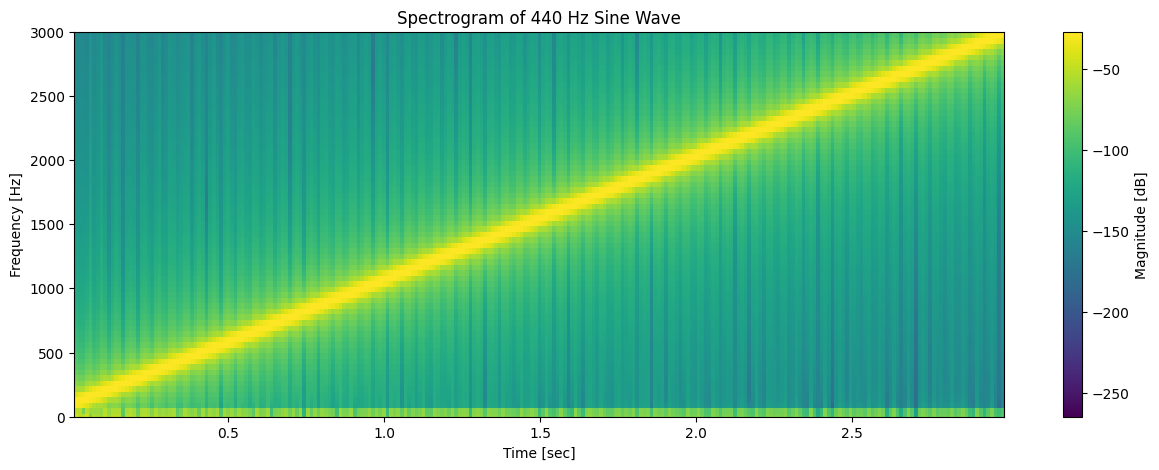

In [ ]:
nperseg = 1024
noverlap = 512
window = signal.windows.hann(nperseg)

frequencies, times, Sxx = signal.spectrogram(lin_inc_wave, sr, 
                                           window=window,
                                           nperseg=nperseg, 
                                           noverlap=noverlap)

plt.figure(figsize=(15, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.title('Spectrogram of 440 Hz Sine Wave')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude [dB]')
plt.ylim(0, 3000)  # Focus on lower frequencies
plt.show()


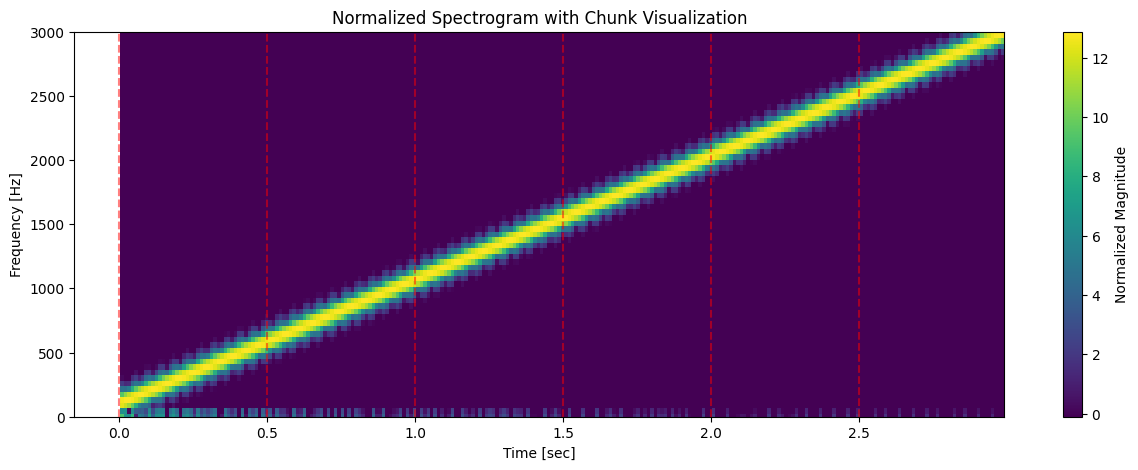

In [ ]:
# Convert to dB, normalize with 50dB threshold
Sxx_db = 10 * np.log10(Sxx)
maxdata = Sxx_db.max()
mindata = maxdata - 50  # dbRES = 50
Sxx_db[Sxx_db < mindata] = mindata
Sxx_norm = Sxx_db - Sxx_db.mean()
Sxx_norm /= Sxx_db.std()

# Calculate nWindow from window_size
window_size = 0.5  # seconds
nWindow = np.where(times >= window_size)[0][0]
if nWindow % 2 == 0:
    nWindow += 1

# Show chunking process
plt.figure(figsize=(15, 5))
plt.pcolormesh(times, frequencies, Sxx_norm)
plt.title('Normalized Spectrogram with Chunk Visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Normalized Magnitude')
plt.ylim(0, 3000)

# Draw vertical lines to show chunks
chunk_times = np.arange(0, times[-1], window_size)
for chunk_time in chunk_times:
    plt.axvline(x=chunk_time, color='r', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# Zero pad spectrogram
pad_width = int((nWindow-1)/2)
sdata = np.pad(Sxx_norm, ((0,0), (pad_width, pad_width)), 
              mode='constant', constant_values=Sxx_norm.min())

# Select chunk from middle
tmid = len(times)//4
tstart = tmid - (nWindow-1)//2 - 1 + pad_width
tend = tmid + (nWindow-1)//2 + pad_width
chunk = deepcopy(sdata[:, tstart:tend])

# Get Gaussian window with correct parameters
_, wg = gaussian_window(nWindow, 6)


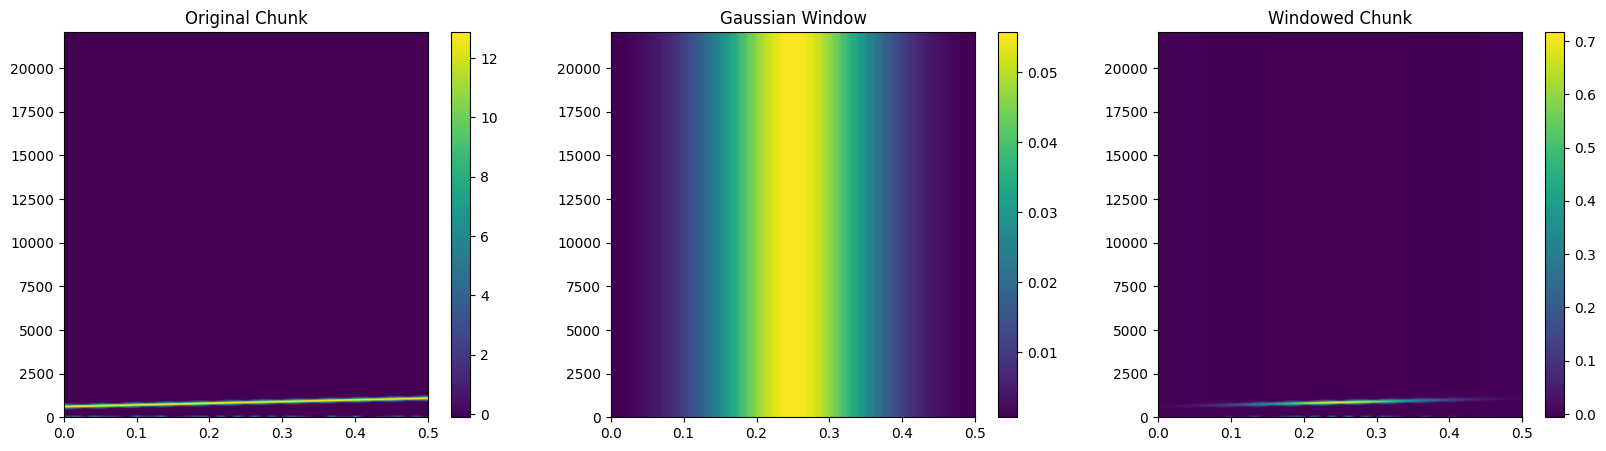

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Original chunk
im0 = axes[0].imshow(chunk, aspect='auto', origin='lower', 
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[0].set_title('Original Chunk')
plt.colorbar(im0, ax=axes[0])

# Gaussian window visualization
window_vis = np.tile(wg, (len(frequencies), 1))
im1 = axes[1].imshow(window_vis, aspect='auto', origin='lower',
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[1].set_title('Gaussian Window')
plt.colorbar(im1, ax=axes[1])

# Apply window per frequency
windowed_chunk = deepcopy(chunk)
for fInd in range(len(frequencies)):
    windowed_chunk[fInd,:] = chunk[fInd,:] * wg

im2 = axes[2].imshow(windowed_chunk, aspect='auto', origin='lower',
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[2].set_title('Windowed Chunk')
plt.colorbar(im2, ax=axes[2])
plt.show()


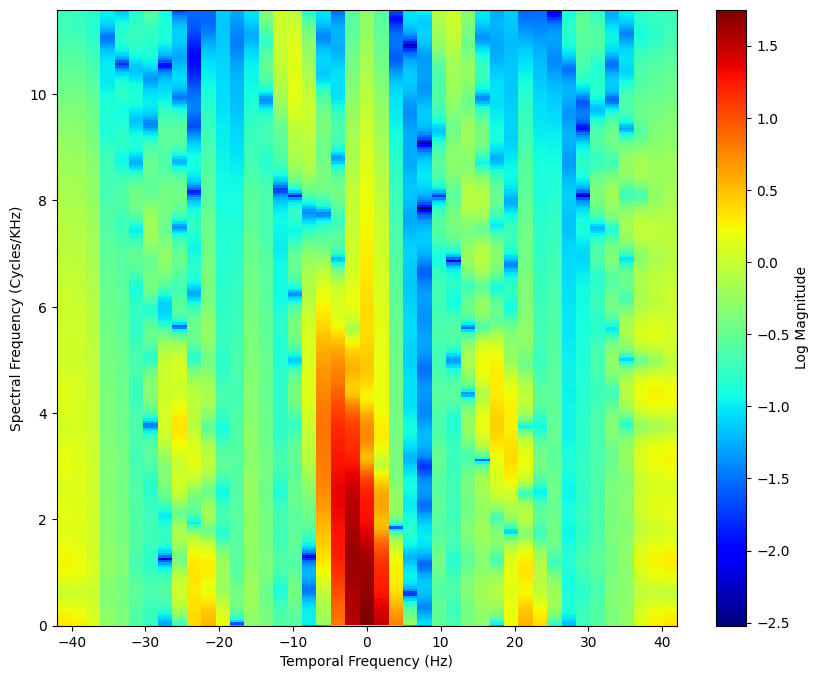

In [ ]:
# FFT and visualization
chunk_fft = np.fft.fft2(windowed_chunk)
chunk_fft_shifted = np.fft.fftshift(np.abs(chunk_fft))
spectral_freq = np.fft.fftfreq(chunk_fft.shape[0], d=frequencies[1]-frequencies[0])
temporal_freq = np.fft.fftfreq(chunk_fft.shape[1], d=window_size/chunk_fft.shape[1])

plt.figure(figsize=(10, 8))
ex = (temporal_freq.min(), temporal_freq.max(), 
      spectral_freq.min()*1e3, spectral_freq.max()*1e3)
plt.imshow(np.log10(chunk_fft_shifted), aspect='auto', origin='lower', extent=ex, cmap=cmap.jet, interpolation='nearest')
plt.ylim(bottom=0)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar(label='Log Magnitude')
plt.show()


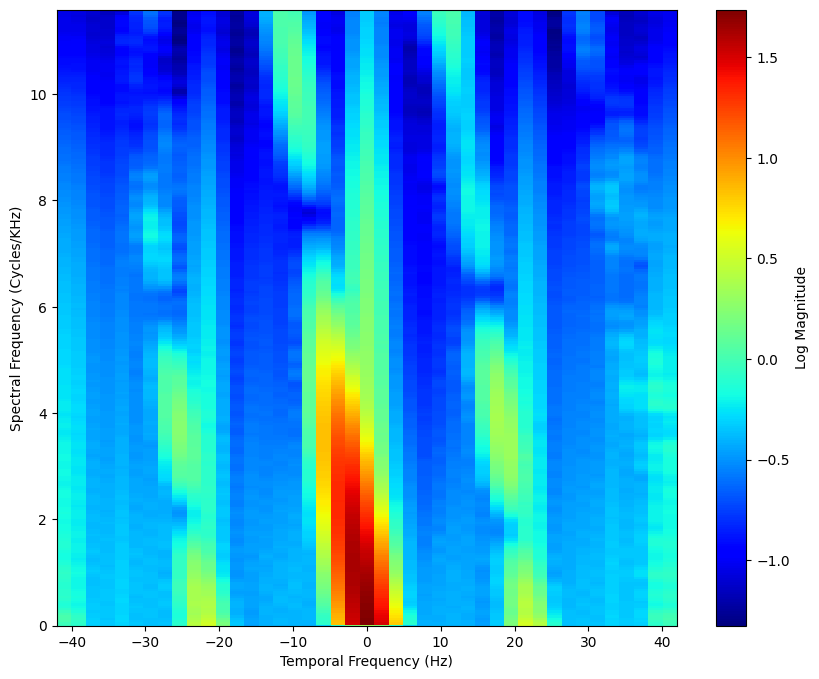

In [ ]:
# Process all chunks
mps_results = []
tShift = int(nWindow/3)

for tmid in range(tShift, len(times), tShift):
    tstart = tmid - (nWindow-1)//2 - 1 + pad_width
    tend = tmid + (nWindow-1)//2 + pad_width
    
    if tend > sdata.shape[1]:
        break
        
    chunk = deepcopy(sdata[:, tstart:tend])
    
    # Apply window per frequency
    windowed_chunk = deepcopy(chunk)
    for fInd in range(len(frequencies)):
        windowed_chunk[fInd,:] = chunk[fInd,:] * wg
        
    # 2D FFT
    chunk_fft = np.fft.fft2(windowed_chunk)
    mps_results.append(np.abs(chunk_fft))

# Average and plot
mps_final = np.mean(mps_results, axis=0)
mps_final_shifted = np.fft.fftshift(mps_final)

plt.figure(figsize=(10, 8))
ex = (temporal_freq.min(), temporal_freq.max(), 
      spectral_freq.min()*1e3, spectral_freq.max()*1e3)
plt.imshow(np.log10(mps_final_shifted), aspect='auto', origin='lower', 
           extent=ex, cmap=cmap.jet, interpolation='nearest')
plt.ylim(bottom=0)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar(label='Log Magnitude')
plt.show()


### (shifted -> means it will cross the filters in another way, shifted to the left -> increasing / shifted to the right -> decreasing)  

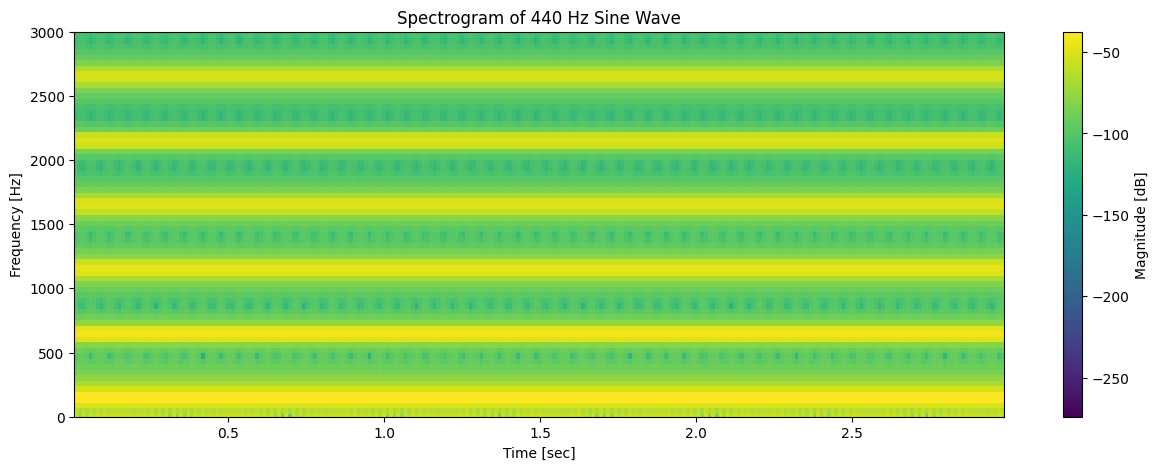

(513, 257)
[[5.28156300e-06 9.94492628e-08 4.23548865e-06 ... 1.43958971e-06
  3.81660584e-06 8.79771170e-07]
 [1.12842943e-06 1.28696352e-07 8.12919499e-07 ... 3.99730481e-07
  7.93250579e-07 2.77655620e-07]
 [7.79793838e-06 7.45702551e-06 7.78536678e-06 ... 7.53992543e-06
  7.72814571e-06 7.51014144e-06]
 ...
 [2.05071255e-21 3.79612596e-24 2.58328225e-24 ... 1.16852784e-24
  5.96793914e-23 4.31676063e-23]
 [2.05016740e-21 3.77191962e-24 2.42169241e-24 ... 1.15270257e-24
  5.94991968e-23 4.32172988e-23]
 [1.02499417e-21 1.88197989e-24 1.18393531e-24 ... 5.73934398e-25
  2.97349075e-23 2.16219295e-23]]


In [ ]:
nperseg = 1024
noverlap = 512
window = signal.windows.hann(nperseg)

frequencies, times, Sxx = signal.spectrogram(harm_500_wave, sr, 
                                           window=window,
                                           nperseg=nperseg, 
                                           noverlap=noverlap)

plt.figure(figsize=(15, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.title('Spectrogram of 440 Hz Sine Wave')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude [dB]')
plt.ylim(0, 3000)  # Focus on lower frequencies
plt.show()

print(Sxx.shape)
print(Sxx)


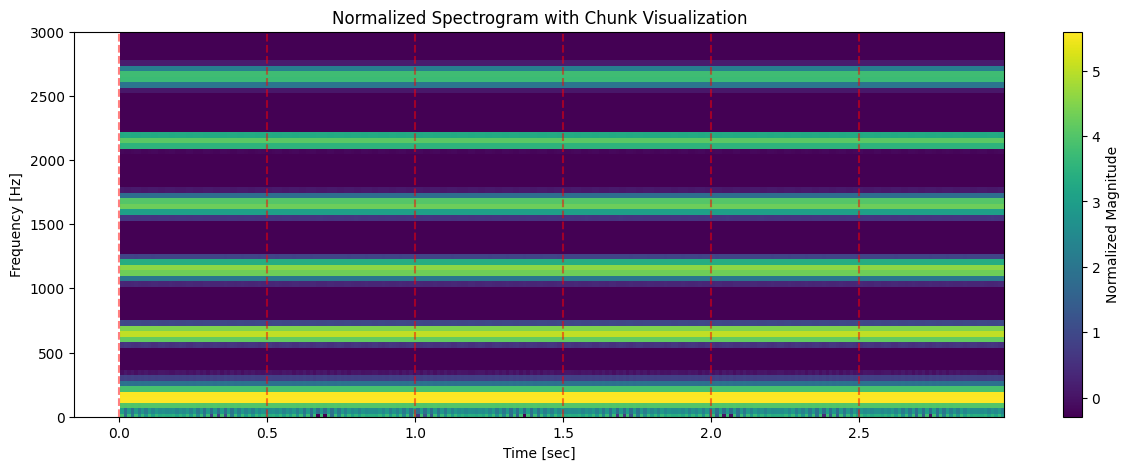

In [ ]:
# Convert to dB, normalize with 50dB threshold
Sxx_db = 10 * np.log10(Sxx)
maxdata = Sxx_db.max()
mindata = maxdata - 50  # dbRES = 50
Sxx_db[Sxx_db < mindata] = mindata
Sxx_norm = Sxx_db - Sxx_db.mean()
Sxx_norm /= Sxx_db.std()

# Calculate nWindow from window_size
window_size = 0.5  # seconds
nWindow = np.where(times >= window_size)[0][0]
if nWindow % 2 == 0:
    nWindow += 1

# Show chunking process
plt.figure(figsize=(15, 5))
plt.pcolormesh(times, frequencies, Sxx_norm)
plt.title('Normalized Spectrogram with Chunk Visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Normalized Magnitude')
plt.ylim(0, 3000)

# Draw vertical lines to show chunks
chunk_times = np.arange(0, times[-1], window_size)
for chunk_time in chunk_times:
    plt.axvline(x=chunk_time, color='r', linestyle='--', alpha=0.5)
plt.show()


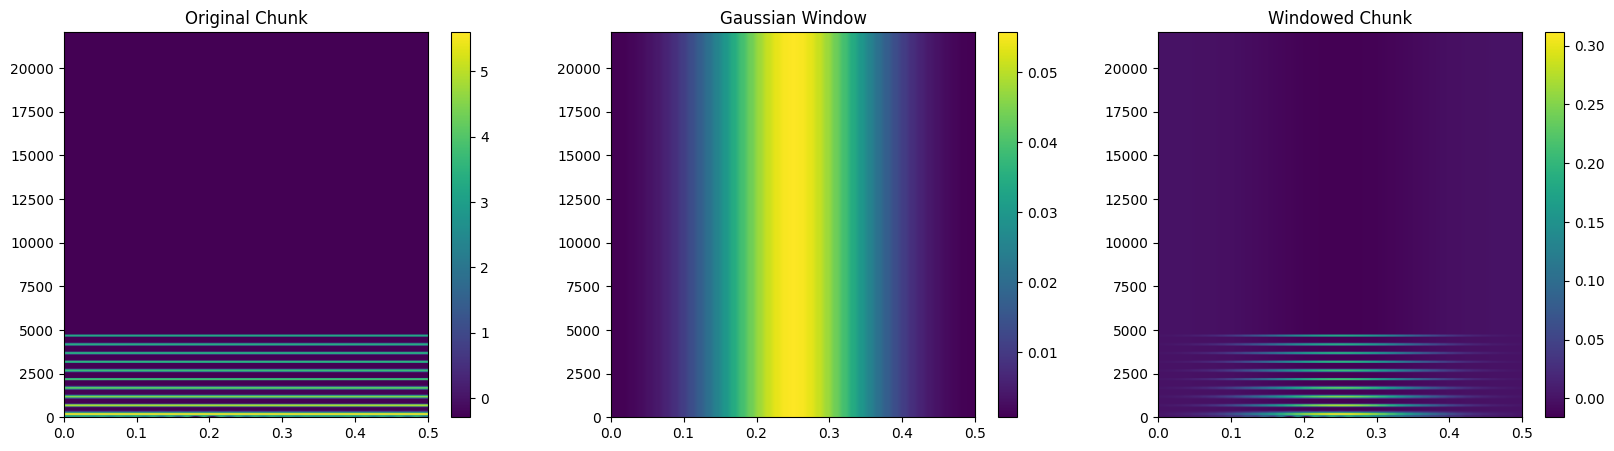

In [ ]:
# Zero pad spectrogram
pad_width = int((nWindow-1)/2)
sdata = np.pad(Sxx_norm, ((0,0), (pad_width, pad_width)), 
              mode='constant', constant_values=Sxx_norm.min())

# Select chunk from middle
tmid = len(times)//4
tstart = tmid - (nWindow-1)//2 - 1 + pad_width
tend = tmid + (nWindow-1)//2 + pad_width
chunk = deepcopy(sdata[:, tstart:tend])

# Get Gaussian window with correct parameters
_, wg = gaussian_window(nWindow, 6)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Original chunk
im0 = axes[0].imshow(chunk, aspect='auto', origin='lower', 
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[0].set_title('Original Chunk')
plt.colorbar(im0, ax=axes[0])

# Gaussian window visualization
window_vis = np.tile(wg, (len(frequencies), 1))
im1 = axes[1].imshow(window_vis, aspect='auto', origin='lower',
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[1].set_title('Gaussian Window')
plt.colorbar(im1, ax=axes[1])

# Apply window per frequency
windowed_chunk = deepcopy(chunk)
for fInd in range(len(frequencies)):
    windowed_chunk[fInd,:] = chunk[fInd,:] * wg

im2 = axes[2].imshow(windowed_chunk, aspect='auto', origin='lower',
               extent=[0, window_size, frequencies[0], frequencies[-1]])
axes[2].set_title('Windowed Chunk')
plt.colorbar(im2, ax=axes[2])
plt.show()


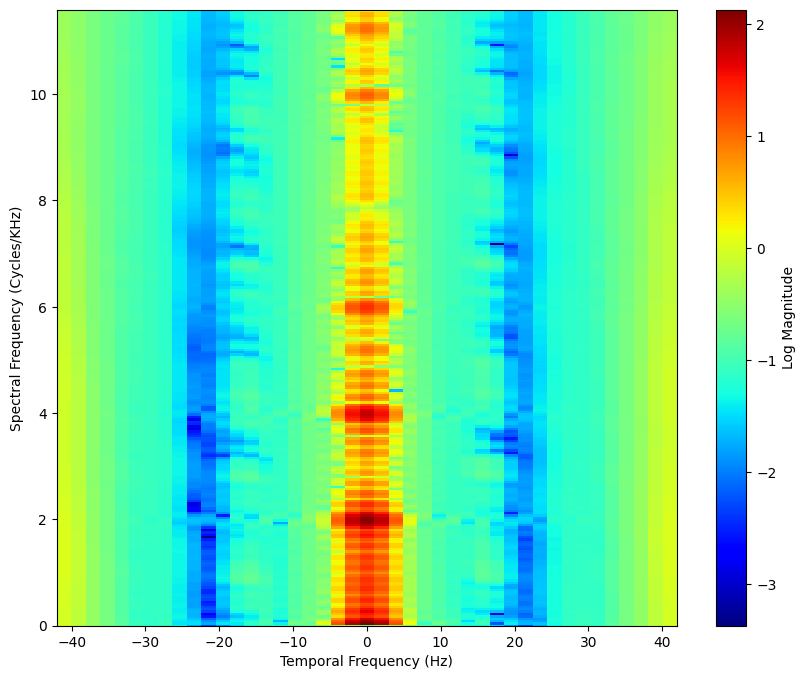

In [ ]:
# FFT and visualization
chunk_fft = np.fft.fft2(windowed_chunk)
chunk_fft_shifted = np.fft.fftshift(np.abs(chunk_fft))
spectral_freq = np.fft.fftfreq(chunk_fft.shape[0], d=frequencies[1]-frequencies[0])
temporal_freq = np.fft.fftfreq(chunk_fft.shape[1], d=window_size/chunk_fft.shape[1])

plt.figure(figsize=(10, 8))
ex = (temporal_freq.min(), temporal_freq.max(), 
      spectral_freq.min()*1e3, spectral_freq.max()*1e3)
plt.imshow(np.log10(chunk_fft_shifted), aspect='auto', origin='lower', extent=ex, cmap=cmap.jet, interpolation='nearest')
plt.ylim(bottom=0)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar(label='Log Magnitude')
plt.show()


[[0.2322882  0.18114197 0.12973757 ... 0.12992272 0.18367912 0.2304193 ]
 [0.23464993 0.1831782  0.13239655 ... 0.132439   0.18513262 0.23303389]
 [0.23467379 0.18550356 0.13331581 ... 0.13277594 0.18438866 0.23529135]
 ...
 [0.23529135 0.18438866 0.13277594 ... 0.13331581 0.18550356 0.23467379]
 [0.23303389 0.18513262 0.132439   ... 0.13239655 0.1831782  0.23464993]
 [0.2304193  0.18367912 0.12992272 ... 0.12973757 0.18114197 0.2322882 ]]


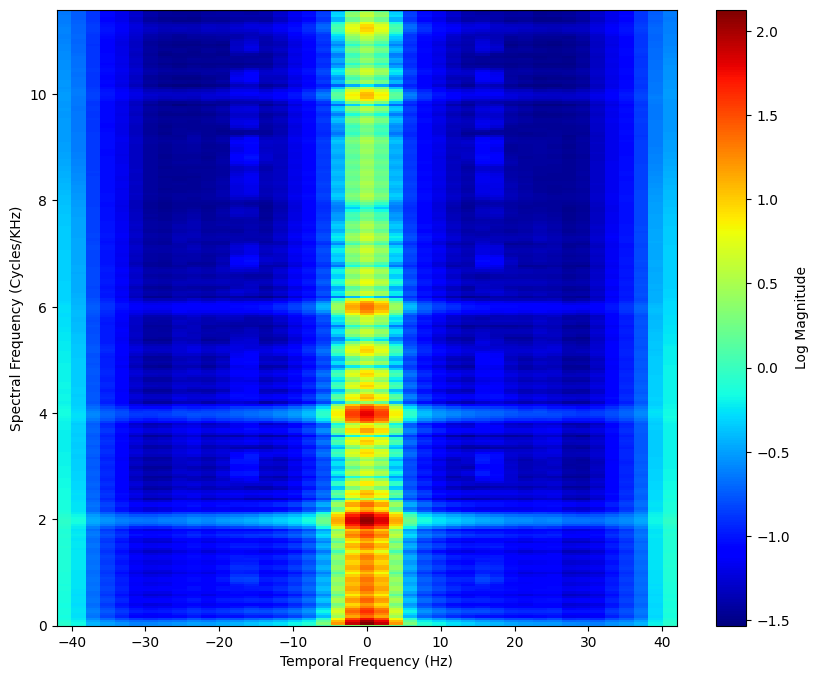

In [ ]:
# Process all chunks
mps_results = []
tShift = int(nWindow/3)

for tmid in range(tShift, len(times), tShift):
    tstart = tmid - (nWindow-1)//2 - 1 + pad_width
    tend = tmid + (nWindow-1)//2 + pad_width
    
    if tend > sdata.shape[1]:
        break
        
    chunk = deepcopy(sdata[:, tstart:tend])
    
    # Apply window per frequency
    windowed_chunk = deepcopy(chunk)
    for fInd in range(len(frequencies)):
        windowed_chunk[fInd,:] = chunk[fInd,:] * wg
        
    # 2D FFT
    chunk_fft = np.fft.fft2(windowed_chunk)
    mps_results.append(np.abs(chunk_fft))

# Average and plot
mps_final = np.mean(mps_results, axis=0)
mps_final_shifted = np.fft.fftshift(mps_final)

print(mps_final_shifted)

plt.figure(figsize=(10, 8))
ex = (temporal_freq.min(), temporal_freq.max(), 
      spectral_freq.min()*1e3, spectral_freq.max()*1e3)
plt.imshow(np.log10(mps_final_shifted), aspect='auto', origin='lower', 
           extent=ex, cmap=cmap.jet, interpolation='nearest')
plt.ylim(bottom=0)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar(label='Log Magnitude')
plt.show()


## (Really have to look at the bottom part)  
## (You can see the cycles in energy for the harmonics and the formants)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import copy
import io
import scipy.io.wavfile as wav

import ipywidgets as widgets
from ipywidgets import VBox, HBox, Layout, Button, IntSlider, FloatSlider, Checkbox, Dropdown
from IPython.display import Audio, display, clear_output

# === File Upload Widget ===
upload_audio = widgets.FileUpload(accept='.wav', multiple=False, description="Upload Audio (.wav)")

# === Helper Functions ===

def apply_fade(wave, sr, fade_duration):
    """Apply a short fade in and fade out to avoid clicks."""
    fade_samples = int(sr * fade_duration)
    envelope = np.ones_like(wave)
    if fade_samples > 0:
        fade_in = np.linspace(0, 1, fade_samples)
        fade_out = np.linspace(1, 0, fade_samples)
        envelope[:fade_samples] = fade_in
        envelope[-fade_samples:] = fade_out
    return wave * envelope

def synthesize_segment(params, sr):
    """
    Synthesize one segment by combining sweep, vibrato, amplitude modulation,
    and harmonics with a constant spacing (in Hz) between partials.
    """
    duration = params['duration']
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    f0 = params['freq']
    
    # --- Frequency Sweep ---
    if params.get('apply_sweep', False):
        target = params['target_freq']
        if params.get('sweep_type', "Linear") == "Linear":
            # Linear sweep: instantaneous frequency goes from f0 to target
            sweep_freq = f0 + (target - f0) * (t / duration)
        else:
            # Exponential sweep
            sweep_freq = f0 * (target / f0) ** (t / duration)
    else:
        sweep_freq = f0 * np.ones_like(t)
    
    # --- Vibrato ---
    if params.get('vibrato', False):
        vibrato_rate = params.get('vibrato_rate', 5)
        vibrato_depth = params.get('vibrato_depth', 30)
        inst_freq = sweep_freq + vibrato_depth * np.sin(2 * np.pi * vibrato_rate * t)
    else:
        inst_freq = sweep_freq

    # --- Compute Phase for the Fundamental ---
    phase = 2 * np.pi * np.cumsum(inst_freq) / sr
    phase = np.mod(phase, 2 * np.pi)  # Wrap phase to avoid numerical issues
    
    # --- Base Waveform (Fundamental) ---
    base_wave = np.sin(phase)
    
    # --- Harmonics with Constant Frequency Gap ---
    if params.get('harmonics', False):
        num_harmonics = params.get('num_harmonics', 10)
        spacing = params.get('harmonic_spacing', 100)  # constant gap in Hz
        harmonic_wave = np.zeros_like(t)
        for n in range(1, num_harmonics + 1):
            # For the nth harmonic, the instantaneous frequency is:
            # f_n(t) = inst_freq + (n-1)*spacing
            phase_n = 2 * np.pi * np.cumsum(inst_freq + (n-1) * spacing) / sr
            phase_n = np.mod(phase_n, 2 * np.pi)
            harmonic_wave += (1.0 / n) * np.sin(phase_n)
        wave = harmonic_wave
    else:
        wave = base_wave
    
    # --- Amplitude Modulation (if enabled) ---
    if params.get('am', False):
        mod_freq = params.get('mod_freq', 2)
        mod_depth = params.get('mod_depth', 0.8)
        modulator = 1 + mod_depth * np.sin(2 * np.pi * mod_freq * t)
        wave = wave * modulator
    
    # --- Normalize and Apply Fade In/Out ---
    max_val = np.max(np.abs(wave))
    if max_val > 0:
        wave = 0.5 * wave / max_val
    else:
        wave = 0.5 * wave
    fade_duration = params.get('fade_duration', 0.1)
    wave = apply_fade(wave, sr, fade_duration)
    
    return t, wave

def compute_spectrogram(wave, sr, nperseg=1024, noverlap=512):
    """Compute the spectrogram and return frequencies, times, normalized dB spectrogram, and raw dB spectrogram."""
    frequencies, times, Sxx = signal.spectrogram(wave, sr, window='hann',
                                                 nperseg=nperseg, noverlap=noverlap)
    Sxx_db = 10 * np.log10(Sxx + 1e-10)
    max_db = np.max(Sxx_db)
    threshold = max_db - 50
    Sxx_db[Sxx_db < threshold] = threshold
    Sxx_norm = (Sxx_db - np.mean(Sxx_db)) / np.std(Sxx_db)
    return frequencies, times, Sxx_norm, Sxx_db

def gaussian_window(N, nstd):
    """Return a Gaussian window of length N (using nstd standard deviations)."""
    hnwinlen = (N + (1 - N % 2)) // 2
    gauss_t = np.arange(-hnwinlen, hnwinlen + 1, 1.0)
    gauss_std = float(N) / float(nstd)
    gauss_window = np.exp(-gauss_t**2 / (2.0 * gauss_std**2)) / (gauss_std * np.sqrt(2 * np.pi))
    return gauss_t, gauss_window

def compute_2d_fft(windowed_chunk, frequencies, window_size):
    """
    Compute the 2D FFT of a windowed spectrogram chunk.
    Returns raw FFT, magnitude, phase, shifted magnitude, and the frequency axes.
    """
    chunk_fft = np.fft.fft2(windowed_chunk)
    fft_mag = np.abs(chunk_fft)
    fft_phase = np.angle(chunk_fft)
    fft_shifted = np.fft.fftshift(fft_mag)
    spectral_freq = np.fft.fftfreq(windowed_chunk.shape[0], d=frequencies[1] - frequencies[0])
    temporal_freq = np.fft.fftfreq(windowed_chunk.shape[1], d=window_size / windowed_chunk.shape[1])
    return chunk_fft, fft_mag, fft_phase, fft_shifted, spectral_freq, temporal_freq

def compute_mps(Sxx_norm, window_size, frequencies, times):
    """
    Compute the mean Modulation Power Spectrum (MPS) by averaging the 2D FFTs
    of overlapping spectrogram chunks. The chunks are extracted using a window
    of length corresponding to window_size (in seconds). 
    
    Returns:
        mps_final_shifted: 2D FFT of the averaged chunk (shifted)
        spectral_freq: frequency axis for the spectral modulation
        temporal_freq: frequency axis for the temporal modulation
    """
    import copy
    # Determine nWindow: number of time bins corresponding to window_size
    try:
        nWindow = np.where(times >= window_size)[0][0]
    except IndexError:
        nWindow = len(times)
    if nWindow % 2 == 0:
        nWindow += 1  # Ensure odd number for symmetric windowing
    pad_width = (nWindow - 1) // 2
    
    # Pad the spectrogram along the time axis
    sdata = np.pad(Sxx_norm, ((0, 0), (pad_width, pad_width)),
                    mode='constant', constant_values=np.min(Sxx_norm))
    
    # Create a Gaussian window for the time dimension
    _, wg = gaussian_window(nWindow, 6)
    
    mps_results = []
    # Define the step size for the sliding window (adjust as desired)
    tShift = int(nWindow // 2)
    
    # Slide over the padded time axis from pad_width to end - pad_width
    for tmid in range(pad_width, sdata.shape[1] - pad_width, tShift):
        tstart = tmid - (nWindow - 1) // 2
        tend = tmid + (nWindow - 1) // 2 + 1  # +1 because slice end is exclusive
        if tend > sdata.shape[1]:
            break
        
        # Extract the chunk (all frequency bins, nWindow time bins)
        chunk = copy.deepcopy(sdata[:, tstart:tend])
        
        # Apply the Gaussian window to each frequency bin
        windowed_chunk = np.empty_like(chunk)
        for fInd in range(chunk.shape[0]):
            windowed_chunk[fInd, :] = chunk[fInd, :] * wg
        
        # Compute the 2D FFT of the windowed chunk and store its magnitude
        chunk_fft = np.fft.fft2(windowed_chunk)
        mps_results.append(np.abs(chunk_fft))
    
    if len(mps_results) == 0:
        return None, None, None
    
    # Average over all chunks
    mps_final = np.mean(mps_results, axis=0)
    mps_final_shifted = np.fft.fftshift(mps_final)
    
    # Compute frequency axes for the MPS:
    spectral_freq = np.fft.fftfreq(nWindow, d=frequencies[1] - frequencies[0])
    temporal_freq = np.fft.fftfreq(nWindow, d=window_size / nWindow)
    
    return mps_final_shifted, spectral_freq, temporal_freq


def compute_mps_for_chunk(sdata, center_index, nWindow, frequencies, window_size):
    """
    Compute the MPS for a given chunk from the padded spectrogram Sxx_norm.
    center_index is the column index in the padded data.
    Returns mps_shifted, spectral_freq, temporal_freq.
    """
    tstart = center_index - (nWindow - 1) // 2 - 1
    tend = center_index + (nWindow - 1) // 2
    if tstart < 0 or tend > sdata.shape[1]:
        return None, None, None
    chunk = copy.deepcopy(sdata[:, tstart:tend])
    _, wg = gaussian_window(nWindow, 6)
    if chunk.shape[1] != len(wg):
        return None, None, None
    windowed_chunk = chunk * wg  # broadcasting applies here
    chunk_fft = np.fft.fft2(windowed_chunk)
    mps = np.abs(chunk_fft)
    mps_shifted = np.fft.fftshift(mps)
    spectral_freq = np.fft.fftfreq(chunk.shape[0], d=frequencies[1]-frequencies[0])
    temporal_freq = np.fft.fftfreq(chunk.shape[1], d=window_size/chunk.shape[1])
    return mps_shifted, spectral_freq, temporal_freq

# === UI for Segment Parameters ===
# Allow up to max_segments segments (only the number chosen will be visible)
max_segments = 5

def create_segment_widgets(index):
    """
    Create widgets for one segment.
    The tone is constant by default. A checkbox allows applying a frequency sweep.
    When enabled, two extra widgets appear: target frequency and sweep type.
    Additional modulations (vibrato, AM, harmonics) are also available.
    """
    fundamental = FloatSlider(value=440, min=50, max=6000, step=10,
                              description="Fundamental (Hz):")
    duration = FloatSlider(value=3.0, min=0.5, max=10.0, step=0.5,
                           description="Duration (s):")
    
    # Frequency sweep widgets:
    apply_sweep_chk = Checkbox(value=False, description="Apply Frequency Sweep?")
    target_freq = FloatSlider(value=440, min=50, max=6000, step=10,
                              description="Target Frequency (Hz):",
                              layout=Layout(display='none'))
    sweep_type = Dropdown(options=["Linear", "Exponential"],
                          value="Linear", description="Sweep Type:",
                          layout=Layout(display='none'))
    
    def on_apply_sweep_chk(change):
        if change['new']:
            target_freq.layout.display = ''
            sweep_type.layout.display = ''
        else:
            target_freq.layout.display = 'none'
            sweep_type.layout.display = 'none'
    apply_sweep_chk.observe(on_apply_sweep_chk, names='value')
    
    # Optional modulation widgets:
    vibrato_chk = Checkbox(value=False, description="Apply Vibrato?")
    vibrato_rate = FloatSlider(value=5, min=0.1, max=30, step=0.1,
                               description="Vibrato Rate (Hz):",
                               layout=Layout(display='none'))
    vibrato_depth = FloatSlider(value=30, min=1, max=300, step=1,
                                description="Vibrato Depth (Hz):",
                                layout=Layout(display='none'))
    
    def on_vibrato_chk(change):
        if change['new']:
            vibrato_rate.layout.display = ''
            vibrato_depth.layout.display = ''
        else:
            vibrato_rate.layout.display = 'none'
            vibrato_depth.layout.display = 'none'
    vibrato_chk.observe(on_vibrato_chk, names='value')
    
    am_chk = Checkbox(value=False, description="Apply Amplitude Modulation?")
    mod_freq = FloatSlider(value=2, min=0.1, max=30, step=0.1,
                           description="Mod Frequency (Hz):",
                           layout=Layout(display='none'))
    mod_depth = FloatSlider(value=0.8, min=0.1, max=3.0, step=0.1,
                            description="Mod Depth:",
                            layout=Layout(display='none'))
    
    def on_am_chk(change):
        if change['new']:
            mod_freq.layout.display = ''
            mod_depth.layout.display = ''
        else:
            mod_freq.layout.display = 'none'
            mod_depth.layout.display = 'none'
    am_chk.observe(on_am_chk, names='value')
    
    harm_chk = Checkbox(value=False, description="Add Harmonics?")
    num_harmonics = IntSlider(value=10, min=1, max=20, step=1,
                              description="Number of Harmonics:",
                              layout=Layout(display='none'))
    harmonic_spacing = IntSlider(value=500, min=100, max=6000, step=50,
                                 description="Harmonic Spacing (Hz):",
                                 layout=Layout(display='none'))
    
    def on_harm_chk(change):
        if change['new']:
            num_harmonics.layout.display = ''
            harmonic_spacing.layout.display = ''
        else:
            num_harmonics.layout.display = 'none'
            harmonic_spacing.layout.display = 'none'
    harm_chk.observe(on_harm_chk, names='value')
    
    segment_box = VBox([fundamental, duration, 
                        apply_sweep_chk, target_freq, sweep_type,
                        vibrato_chk, vibrato_rate, vibrato_depth,
                        am_chk, mod_freq, mod_depth,
                        harm_chk, num_harmonics, harmonic_spacing])
    widget_dict = {
        "fundamental": fundamental,
        "duration": duration,
        "apply_sweep": apply_sweep_chk,
        "target_freq": target_freq,
        "sweep_type": sweep_type,
        "vibrato": vibrato_chk,
        "vibrato_rate": vibrato_rate,
        "vibrato_depth": vibrato_depth,
        "am": am_chk,
        "mod_freq": mod_freq,
        "mod_depth": mod_depth,
        "harmonics": harm_chk,
        "num_harmonics": num_harmonics,
        "harmonic_spacing": harmonic_spacing
    }
    return segment_box, widget_dict

# Create widget sets for up to max_segments (only the number chosen will be visible)
segment_widgets = []
segment_widget_dicts = []
for i in range(max_segments):
    box, wdict = create_segment_widgets(i)
    segment_widgets.append(box)
    segment_widget_dicts.append(wdict)

# Slider to choose how many segments you want
num_segments_widget = IntSlider(value=1, min=1, max=max_segments, step=1,
                                description="Number of Segments:")

# Container for the visible segment widgets
segments_container = VBox(segment_widgets[:num_segments_widget.value])
def update_segments_container(change):
    count = change['new']
    segments_container.children = segment_widgets[:count]
num_segments_widget.observe(update_segments_container, names='value')

# --- Global Analysis Options ---
global_fade = FloatSlider(value=0.1, min=0, max=1, step=0.05,
                          description="Fade Duration (s):")
global_window_size = FloatSlider(value=0.5, min=0.1, max=2.0, step=0.1,
                                 description="MPS Window Size (s):")
# Set these FFT options to False by default
show_fft1d_global = Checkbox(value=False, description="Show 1D FFT")
show_fft2d_global = Checkbox(value=False, description="Show 2D FFT")
show_mps_global = Checkbox(value=True, description="Show MPS")

# New: Global widget for silence duration between segments (if > 1)
global_silence = FloatSlider(value=0.0, min=0.0, max=2.0, step=0.1,
                             description="Silence Between Segments (s):")

# --- The "Generate and Analyze" Button and Output Area ---
generate_button = Button(description="Generate and Analyze Sound", button_style='success')
output_area = widgets.Output()

# --- Audio Source Selection ---
audio_source = Dropdown(options=["Synthetic Audio", "Uploaded Audio"],
                        value="Synthetic Audio",
                        description="Audio Source:")

def on_generate_clicked(b):
    with output_area:
        clear_output(wait=True)
        sr = 44100  # Fixed sample rate (adjust if desired)

        # Choose audio source based on the toggle
        if audio_source.value == "Uploaded Audio":
            # Use uploaded file
            file_val = upload_audio.value
            if file_val:
                if isinstance(file_val, dict):
                    file_info = list(file_val.values())[0]
                elif isinstance(file_val, (list, tuple)):
                    file_info = file_val[0]
                else:
                    file_info = None

                if file_info is not None:
                    # Read the WAV file from bytes
                    sr, composite_wave = wav.read(io.BytesIO(file_info['content']))
                    # If stereo, convert to mono by taking the mean of channels.
                    if composite_wave.ndim > 1:
                        composite_wave = composite_wave.mean(axis=1)
                    # Convert to float in range -1 to 1 if necessary
                    if composite_wave.dtype not in [np.float32, np.float64]:
                        composite_wave = composite_wave.astype(np.float32) / np.iinfo(composite_wave.dtype).max
                    composite_time = np.linspace(0, len(composite_wave)/sr, len(composite_wave), endpoint=False)
                else:
                    print("No valid file found. Falling back to synthetic audio.")
                    composite_wave, composite_time = generate_synthetic(sr)
            else:
                print("No file uploaded. Falling back to synthetic audio.")
                composite_wave, composite_time = generate_synthetic(sr)
        else:
            # Use synthetic audio
            composite_wave, composite_time = generate_synthetic(sr)

        # --- Display the synthesized or uploaded sound ---
        display(Audio(composite_wave, rate=sr))

        # --- Plot the overall waveform ---
        plt.figure(figsize=(12, 3))
        plt.plot(composite_time, composite_wave)
        plt.title("Composite Waveform")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

        # --- Compute and plot the spectrogram ---
        nperseg = 1024
        noverlap = 512
        frequencies, times, Sxx_norm, Sxx_db = compute_spectrogram(composite_wave, sr, nperseg, noverlap)
        plt.figure(figsize=(12, 4))
        plt.pcolormesh(times, frequencies, Sxx_norm, shading='gouraud', cmap='jet')
        plt.title("Normalized Spectrogram (50 dB Threshold)")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.ylim(top=22000)
        plt.colorbar(label='Normalized Magnitude')
        # Mark equally spaced time chunks (using the global window size)
        win = global_window_size.value
        chunk_times = np.arange(0, composite_time[-1] + win, win)
        for ct in chunk_times:
            plt.axvline(x=ct, color='r', linestyle='--', alpha=0.7)
        plt.show()

        # --- Optional: Plot 1D FFT of the composite wave ---
        if show_fft1d_global.value:
            fft_result = np.fft.fft(composite_wave)
            fft_freq = np.fft.fftfreq(len(composite_wave), 1/sr)
            pos_mask = fft_freq >= 0
            plt.figure(figsize=(12, 3))
            plt.plot(fft_freq[pos_mask], np.abs(fft_result[pos_mask]))
            plt.title("1D FFT of Composite Wave")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude")
            plt.xlim(0, sr/2)
            plt.grid(True)
            plt.show()

        # --- Optional: 2D FFT on one spectrogram chunk ---
        if show_fft2d_global.value:
            try:
                nWindow = np.where(times >= global_window_size.value)[0][0]
            except IndexError:
                nWindow = len(times)
            if nWindow % 2 == 0:
                nWindow += 1
            pad_width = int((nWindow - 1) // 2)
            sdata = np.pad(Sxx_norm, ((0, 0), (pad_width, pad_width)),
                           mode='constant', constant_values=np.min(Sxx_norm))
            tmid = len(times) // 4 + pad_width
            tstart = tmid - (nWindow - 1) // 2 - 1
            tend = tmid + (nWindow - 1) // 2
            if tend <= sdata.shape[1]:
                chunk = copy.deepcopy(sdata[:, tstart:tend])
                _, wg = gaussian_window(nWindow, 6)
                if chunk.shape[1] == len(wg):
                    windowed_chunk = copy.deepcopy(chunk)
                    for fInd in range(windowed_chunk.shape[0]):
                        windowed_chunk[fInd, :] *= wg
                    chunk_fft, fft_mag, fft_phase, fft_shifted, spectral_freq, temporal_freq = \
                        compute_2d_fft(windowed_chunk, frequencies, global_window_size.value)
                    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
                    im0 = axes[0].imshow(chunk, aspect='auto', origin='lower', cmap='jet')
                    axes[0].set_title("Spectrogram Chunk (Windowed)")
                    axes[0].set_xlabel("Time Bin")
                    axes[0].set_ylabel("Frequency Bin")
                    fig.colorbar(im0, ax=axes[0])
                    
                    im1 = axes[1].imshow(np.log10(fft_mag + 1e-10), aspect='auto', origin='lower', cmap='jet')
                    axes[1].set_title("2D FFT Magnitude (Log Scale)")
                    axes[1].set_xlabel("Temporal Bin")
                    axes[1].set_ylabel("Spectral Bin")
                    fig.colorbar(im1, ax=axes[1])
                    
                    im2 = axes[2].imshow(np.log10(fft_shifted + 1e-10), aspect='auto', origin='lower', cmap='jet')
                    axes[2].set_title("Shifted 2D FFT (Log Scale)")
                    axes[2].set_xlabel("Temporal Frequency Bin")
                    axes[2].set_ylabel("Spectral Frequency Bin")
                    fig.colorbar(im2, ax=axes[2])
                    plt.tight_layout()
                    plt.show()

        # --- Optional: Compute and plot the Mean Modulation Power Spectrum (MPS) ---
        if show_mps_global.value:
            mps_shifted, spec_freq, temp_freq = compute_mps(Sxx_norm, global_window_size.value, frequencies, times)
            if mps_shifted is not None:
                ex = (temp_freq.min(), temp_freq.max(), spec_freq.min() * 1e3, spec_freq.max() * 1e3)
                plt.figure(figsize=(12, 4))
                plt.imshow(np.log10(mps_shifted + 1e-10), aspect='auto', origin='lower', extent=ex, cmap='jet')
                plt.title("Mean Modulation Power Spectrum (MPS)")
                plt.xlabel("Temporal Frequency (Hz)")
                plt.ylabel("Spectral Frequency (Cycles/KHz)")
                plt.ylim(bottom=0)
                plt.colorbar(label='Log Magnitude')
                plt.show()
                
            # --- New: Plot up to 4 random MPS chunks in one row ---
            try:
                nWindow = np.where(times >= global_window_size.value)[0][0]
            except IndexError:
                nWindow = len(times)
            if nWindow % 2 == 0:
                nWindow += 1
            pad_width = int((nWindow - 1) // 2)
            sdata = np.pad(Sxx_norm, ((0,0), (pad_width, pad_width)),
                            mode='constant', constant_values=np.min(Sxx_norm))
            # Define valid center indices in the padded data:
            valid_min = pad_width + (nWindow - 1) // 2 + 1
            valid_max = sdata.shape[1] - ((nWindow - 1) // 2)
            if valid_max > valid_min:
                num_candidates = min(4, valid_max - valid_min)
                random_centers = np.sort(np.random.choice(np.arange(valid_min, valid_max), size=num_candidates, replace=False))
                fig, axes = plt.subplots(1, num_candidates, figsize=(4*num_candidates, 4))
                if num_candidates == 1:
                    axes = [axes]
                for ax, center in zip(axes, random_centers):
                    mps_chunk, spec_freq, temp_freq = compute_mps_for_chunk(sdata, center, nWindow, frequencies, global_window_size.value)
                    if mps_chunk is not None:
                        ex = (temp_freq.min(), temp_freq.max(), spec_freq.min() * 1e3, spec_freq.max() * 1e3)
                        ax.imshow(np.log10(mps_chunk + 1e-10), aspect='auto', origin='lower', extent=ex, cmap='jet')
                        ax.set_title("MPS Chunk")
                        ax.set_xlabel("Temporal Frequency (Hz)")
                        ax.set_ylabel("Spectral Frequency (Cycles/KHz)")
                        ax.set_ylim(bottom=0)
                plt.tight_layout()
                plt.show()

# Helper to synthesize sound if needed.
def generate_synthetic(sr):
    composite_wave = np.array([])
    composite_time = np.array([])
    current_time = 0
    num_segments = num_segments_widget.value
    for i in range(num_segments):
        wd = segment_widget_dicts[i]
        params = {}
        params['freq'] = wd['fundamental'].value
        params['duration'] = wd['duration'].value
        params['fade_duration'] = global_fade.value
        if wd['apply_sweep'].value:
            params['apply_sweep'] = True
            params['target_freq'] = wd['target_freq'].value
            params['sweep_type'] = wd['sweep_type'].value
        else:
            params['apply_sweep'] = False
        if wd['vibrato'].value:
            params['vibrato'] = True
            params['vibrato_rate'] = wd['vibrato_rate'].value
            params['vibrato_depth'] = wd['vibrato_depth'].value
        if wd['am'].value:
            params['am'] = True
            params['mod_freq'] = wd['mod_freq'].value
            params['mod_depth'] = wd['mod_depth'].value
        if wd['harmonics'].value:
            params['harmonics'] = True
            params['num_harmonics'] = wd['num_harmonics'].value
            params['harmonic_spacing'] = wd['harmonic_spacing'].value
        t_seg, wave_seg = synthesize_segment(params, sr)
        t_seg = t_seg + current_time
        current_time += params['duration']
        composite_wave = np.concatenate((composite_wave, wave_seg))
        composite_time = np.concatenate((composite_time, t_seg))
        if num_segments > 1 and i < num_segments - 1:
            silence_duration = global_silence.value
            if silence_duration > 0:
                t_silence = np.linspace(0, silence_duration, int(sr * silence_duration), endpoint=False)
                silence_wave = np.zeros_like(t_silence)
                t_silence = t_silence + current_time
                composite_wave = np.concatenate((composite_wave, silence_wave))
                composite_time = np.concatenate((composite_time, t_silence))
                current_time += silence_duration
    return composite_wave, composite_time

# Bind the callback to the button
generate_button.on_click(on_generate_clicked)



global_ui = VBox([
    audio_source,      
    upload_audio,    
    num_segments_widget,
    segments_container,
    global_fade,
    global_window_size,
    global_silence,
    HBox([show_fft1d_global, show_fft2d_global, show_mps_global]),
    generate_button,
    output_area
])

display(global_ui)



### (window size -> very important according to the sound -> check how long is the signal to choose the right window size)  
### ()

# But in practice?

### Import and install packages

Do !pip install soundsig 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from soundsig.sound import BioSound 
from soundsig.sound import WavFile
import os

%matplotlib inline


### Choose the folder where you have your audio files

In [ ]:
os.chdir('/home/baptiste/MASTER1/S2/DataMining/project/data/Propagation_experiments/individuals_propagation/12_5_m/')

if not os.path.exists('h5files'):
    os.makedirs('h5files')


### Compute MPS on all the data and save them in a folder called h5files as h5 files (inside the folder where you have your audio files)

In [ ]:
# Plot flag to decide whether or not to plot output
plotMe = False
normalize = True

# Find all the wave files 
isound = 0   
for fname in os.listdir('.'):
    if fname.endswith('.wav'):
        isound += 1
            
        # Print the processing sound file
        print('Processing sound {}:{}'.format(isound, fname))
            
        # Create WavFile object with mono=True
        soundIn = WavFile(file_name=fname, mono=True)
        filename, file_extension = os.path.splitext(fname)
            
        parts = filename.split('_')
        subject = '_'.join(parts[1:-1])  + '.wav'   
        syllable = parts[0]  
        
        # Normalize if wanted
        if normalize :
            maxAmp = np.abs(soundIn.data).max() 
        else :
            maxAmp = 1.0
    
    # Create BioSound Object
        myBioSound = BioSound(soundWave=soundIn.data.astype(float)/maxAmp, fs=float(soundIn.sample_rate), emitter=subject, calltype = syllable)
             
    # Calculate the spectrogram and the rms
        myBioSound.spectroCalc(spec_sample_rate=250, freq_spacing = 100, min_freq=0, max_freq=8000)
        myBioSound.rms = myBioSound.sound.std() 
       
    # Calculate amplitude enveloppe
        myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 100)
       
    # Calculate the power spectrum
        myBioSound.spectrum(f_high=10000)
      
    # Calculate the MPS
        myBioSound.mpsCalc(window=0.08, Norm = True) #old window=0.1
                
        if plotMe and isound <= 20: 
            print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
            print('                Bird %s    Call Type %s' % (myBioSound.emitter, myBioSound.type))
            myBioSound.plot(DBNOISE=50, f_low=0, f_high=10000)  
            print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

    # Save the results
        fh5name = 'h5files/%s.h5' % (filename)
        myBioSound.saveh5(fh5name)


Processing sound 1:N_segment_46_12-5m.wav
Processing sound 2:L_segment_30_12-5m.wav
Processing sound 3:L_segment_27_12-5m.wav
Processing sound 4:L_segment_21_12-5m.wav
Processing sound 5:Z_segment_98_12-5m.wav
Processing sound 6:NMC_segment_66_12-5m.wav
Processing sound 7:NMD_segment_72_12-5m.wav
Processing sound 8:NMC_segment_61_12-5m.wav
Processing sound 9:L_segment_25_12-5m.wav
Processing sound 10:NMA_segment_55_12-5m.wav
Processing sound 11:O_segment_8_12-5m.wav
Processing sound 12:NMA_segment_52_12-5m.wav
Processing sound 13:O_segment_7_12-5m.wav
Processing sound 14:NME_segment_90_12-5m.wav
Processing sound 15:M_segment_37_12-5m.wav
Processing sound 16:NME_segment_84_12-5m.wav
Processing sound 17:Z_segment_96_12-5m.wav
Processing sound 18:N_segment_44_12-5m.wav
Processing sound 19:Z_segment_93_12-5m.wav
Processing sound 20:NMA_segment_56_12-5m.wav
Processing sound 21:K_segment_14_12-5m.wav
Processing sound 22:NMA_segment_59_12-5m.wav
Processing sound 23:N_segment_42_12-5m.wav
Proc

## MPS Analysis, how to use MPS in bioacoustics? 

### Import and install packages

In [ ]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.sound import BioSound 

import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import umap
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


In [ ]:
# Go to the folder that has the h5 files corresponding to the BioSound objects.
os.chdir('/home/baptiste/MASTER1/S2/DataMining/project/data/Propagation_experiments/individuals_propagation/12_5_m/h5files/')
meta_data = pd.read_csv('/home/baptiste/MASTER1/S2/DataMining/project/files/audio_metadata.csv')
# Color map
cmap = plt.get_cmap('jet')


In [ ]:
# Read first one to set up plotting parameters and store the size of the MPS and count the other ones (lazy code...)

count = 0
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        if (count == 0):
            myBioSound = BioSound()
            myBioSound.readh5(fname)        
        count += 1

# Cut the mps to central region 
wfInd = np.argwhere(myBioSound.wf >= 0).flatten()
wtInd = np.argwhere((myBioSound.wt >= -100) & (myBioSound.wt <=100) ).flatten()

shapeDesired = (len(wfInd), len(wtInd))

ex = (myBioSound.wt[wtInd[0]], myBioSound.wt[wtInd[-1]], myBioSound.wf[wfInd[0]]*1e3, myBioSound.wf[wfInd[-1]]*1e3)

print(myBioSound.wf)


[-0.00483596 -0.00471196 -0.00458796 -0.00446396 -0.00433996 -0.00421596
 -0.00409197 -0.00396797 -0.00384397 -0.00371997 -0.00359597 -0.00347197
 -0.00334797 -0.00322397 -0.00309997 -0.00297598 -0.00285198 -0.00272798
 -0.00260398 -0.00247998 -0.00235598 -0.00223198 -0.00210798 -0.00198398
 -0.00185998 -0.00173599 -0.00161199 -0.00148799 -0.00136399 -0.00123999
 -0.00111599 -0.00099199 -0.00086799 -0.00074399 -0.00061999 -0.000496
 -0.000372   -0.000248   -0.000124    0.          0.000124    0.000248
  0.000372    0.000496    0.00061999  0.00074399  0.00086799  0.00099199
  0.00111599  0.00123999  0.00136399  0.00148799  0.00161199  0.00173599
  0.00185998  0.00198398  0.00210798  0.00223198  0.00235598  0.00247998
  0.00260398  0.00272798  0.00285198  0.00297598  0.00309997  0.00322397
  0.00334797  0.00347197  0.00359597  0.00371997  0.00384397  0.00396797
  0.00409197  0.00421596  0.00433996  0.00446396  0.00458796  0.00471196
  0.00483596]


In [ ]:
# Allocate space for MPS - you can skip the next set of cells if you already have the PCA

X = np.zeros((count, shapeDesired[0]*shapeDesired[1]))
print('Allocated space for all MPS') 

wfi, wtj = np.meshgrid(wfInd, wtInd, indexing = 'ij')


Allocated space for all MPS


In [ ]:
wf0 = np.argwhere(myBioSound.wf == 0).flatten()[0]
wt0 = np.argwhere(myBioSound.wt == 0).flatten()[0]


In [ ]:
X.shape


(100, 680)

In [ ]:
# Loop again to extract the central section of the MPS and store the in X 

# Looping again through all the files
count = 0
count_valid = 0
dcVals = []
sumVals = []
callIDs = []
fileIDs = []

for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        
        # Allocate object and read data
        myBioSound = BioSound()
        myBioSound.readh5(fname)

        file = fname.replace('.h5', '.wav')  # Adjusting the filename for matching

        matched_rows = meta_data[meta_data['file_name'] == file]

        print(myBioSound.mps.shape)
        
        if not matched_rows.empty:
            row = matched_rows.iloc[0]  # Get the first matching row
            #print('row is matching')
            
            # Extract values
            call_type = row['signal_type']
            file = row['file_name']

            print('Read %d files and mps' % count)
            print('DC: Mean = ', np.mean(dcVals), 'SD = ', np.std(dcVals), 'CV = ', np.std(dcVals)/np.mean(dcVals))
            print('Sum: Mean = ', np.mean(sumVals), 'SD = ', np.std(sumVals), 'CV = ', np.std(sumVals)/np.mean(sumVals))

            X[count,:] = np.log(np.ravel(myBioSound.mps[wfi, wtj]))

            callIDs.append(call_type)
            fileIDs.append(file)

            dcval = np.log(myBioSound.mps[wf0, wt0])
            sumval = np.sum(X[count,:])
            dcVals.append(dcval)
            sumVals.append(sumval)
        
            count +=1

        else:
            pass


(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)
(79, 21)


In [ ]:
ex = (myBioSound.wt[wtInd[0]], myBioSound.wt[wtInd[-1]], myBioSound.wf[wfInd[0]]*1e3, myBioSound.wf[wfInd[-1]]*1e3)


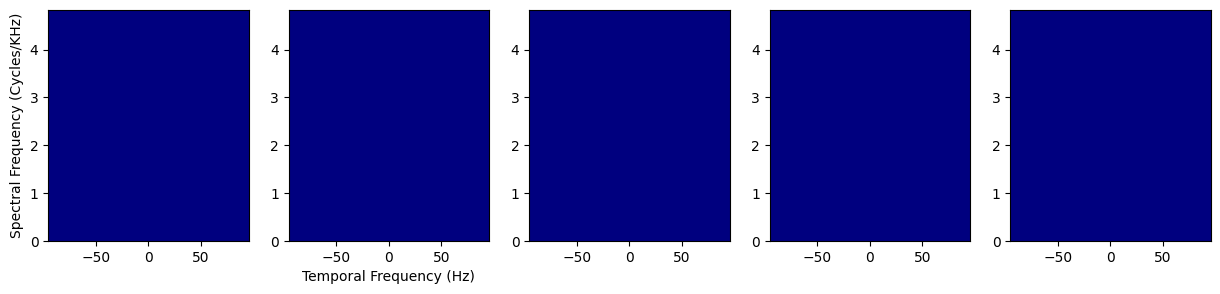

In [ ]:
# Display the first 5 PCs
NPLOTS = 5

plt.figure(figsize=(15,3))
plt.clf()

for iplot in range(NPLOTS):
    plt.subplot(100+NPLOTS*10+1+iplot)
    MPS = np.reshape(X[iplot], (shapeDesired[0],shapeDesired[1]))
    # maxMPS = MPS.max()
    
    #minMPS = maxMPS-DBNOISE
    # logMPS[logMPS < minMPS] = minMPS
    plt.imshow(MPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    if (iplot == 0) :
        plt.ylabel('Spectral Frequency (Cycles/KHz)')
    if (iplot == 1) :
        plt.xlabel('Temporal Frequency (Hz)')

    #plt.clim(-0.05, 0.05)
    #plt.title('Call type: '+ callIDs[iplot])
 
plt.show()


In [ ]:
#change also here with the categories you chose
data_dict = {
    'call_type': callIDs,
    'file': fileIDs
}

list_df = pd.DataFrame(data_dict)


In [ ]:
# Perform an initial dimensionality reduction.
#nPCs is the number of PCs that will be used in the first dimensionality reduction
nPCs = 5

print('Performing PCA')

pca = PCA(n_components=nPCs)
Xr = pca.fit_transform(X)  
 
print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))


Performing PCA
Variance explained is nan%


/home/baptiste/MASTER1/.venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


In [ ]:
Xr_df = pd.DataFrame(Xr)
data = pd.concat([Xr_df, list_df], axis=1)
data.head()
data.to_csv('/home/baptiste/MASTER1/S2/DataMining/project/files/data_mps.csv')


/tmp/ipykernel_48578/458884817.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Call Type', bbox_to_anchor=(1.05, 1), loc='upper left')


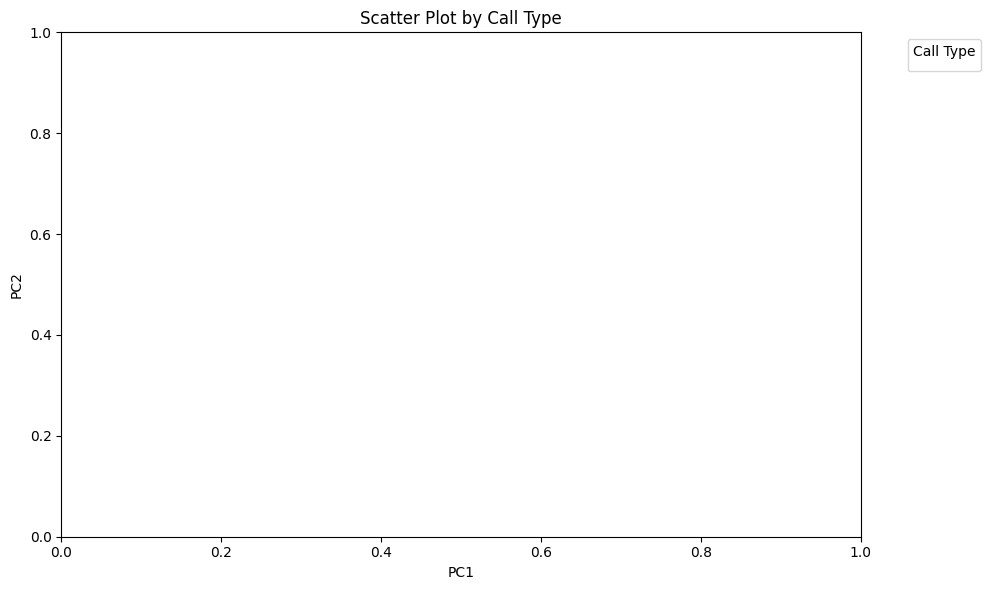

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, 
                x=data.columns[0],  # First column
                y=data.columns[1],  # Second column
                hue='call_type') 

# Customize the plot
plt.title('Scatter Plot by Call Type')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Adjust legend position
plt.legend(title='Call Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
X = data.iloc[:, :2].values
le = LabelEncoder()
y = le.fit_transform(data['call_type'])

svm = SVC(kernel='rbf', probability=True)
svm.fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = go.Figure()

fig.add_trace(go.Contour(
    x=np.arange(x_min, x_max, 0.1),
    y=np.arange(y_min, y_max, 0.1),
    z=Z,
    colorscale='RdBu',
    opacity=0.6,
    showscale=False
))

unique_classes = np.unique(y)
class_names = le.inverse_transform(unique_classes)

for class_idx, class_name in zip(unique_classes, class_names):
    mask = y == class_idx
    fig.add_trace(go.Scatter(
        x=X[mask, 0],
        y=X[mask, 1],
        mode='markers',
        name=class_name,
        marker=dict(size=8),
        hovertext=data[mask]['file'],
        hoverinfo='text'
    ))

fig.update_layout(
    title='SVM Decision Boundary',
    xaxis_title='PC1',
    yaxis_title='PC2',
    width=900,
    height=600,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    )
)

fig.show()

y_pred = svm.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"SVM Classification Accuracy: {accuracy:.2%}")


ValueError: The number of classes has to be greater than one; got 1 class